**Part 2: Training**

# Libraries

In [1]:
# drive
from google.colab import drive
drive.mount('/content/drive')

# utils library with functions
! cp drive/MyDrive/industrylab/Notebooks/utils.py ./utils.py
from utils import *

# generic
import pandas as pd
import numpy as np
import joblib
import json
import os

# graphics
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (13,7)
plt.rcParams["figure.figsize"] = (13,7)

# ml
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
import keras
import tensorflow as tf
from keras import layers, callbacks, models


np.random.seed(0)
tf.random.set_seed(0)

Mounted at /content/drive


In [2]:
base_path = "/content/drive/MyDrive/industrylab/"

# Load files

In [3]:
# load files
data_tot = import_files(base_path, targets, prevs)

# load scaler
scaler = get_scaler(base_path)

# Model Training

## SVR

### SVR livello

In [ ]:
target = 'livello'

In [ ]:
tmp_offsets = [1, 7, 28]
tmp_prevs = [1, 7, 28, 70, 112]
kernels = ['poly', 'rbf']
epsilons = [0.001, 0.005, 0.01, 0.05, 0.1]

tot = []

for offset in tmp_offsets:
  rows = []

  for prev in tmp_prevs:
    row = []
    print(offset, '|', prev)

    # read files
    X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, prev, offset)

    # reshape
    X_train = X_train.reshape(len(X_train),-1)
    X_val = X_val.reshape(len(X_val),-1)
    X_test = X_test.reshape(len(X_test),-1)

    for kernel in kernels:
      
      for epsilon in epsilons:

        for deg in [2, 3, 4]:
          # initialize
          svr = SVR(kernel=kernel, C=1, epsilon=epsilon, degree=deg)

          # fit
          svr.fit(X_train, y_train.ravel())

          # make predictions on validation
          y_pred = scaler[target].inverse_transform(svr.predict(X_val).reshape(-1,1))
          y_true = scaler[target].inverse_transform(np.array(y_val).reshape(-1,1))

          # calculate mae on validation
          mae = mean_absolute_error(y_true, y_pred)
          
          if kernel == 'rbf':
            row.append([kernel+'_'+str(epsilon),int(prev), round(mae, 2)])
            break # do it only with one deg
          else:
            row.append([kernel+str(deg)+'_'+str(epsilon),int(prev), round(mae, 2)])

    rows.append(row)
  tot.append(rows)

1 | 1
1 | 7
1 | 28
1 | 70
1 | 112
7 | 1
7 | 7
7 | 28
7 | 70
7 | 112
28 | 1
28 | 7
28 | 28
28 | 70
28 | 112


In [ ]:
# for i in range(len(tmp_offsets)):
#   offset = tmp_offsets[i]
#   tmp = tot[i]
#   df = pd.DataFrame(np.array(tmp).reshape(20*5, 3), columns=['name', 'prev', 'mae']).round(2)
#   df['mae'] = df['mae'].astype('float64').round(2)
#   df['prev'] =df['prev'].astype('int32')
#   df.to_csv(base_path+'Models/svr/svr_livello_offset'+str(offset)+'_hyperparameters.csv', index=False)

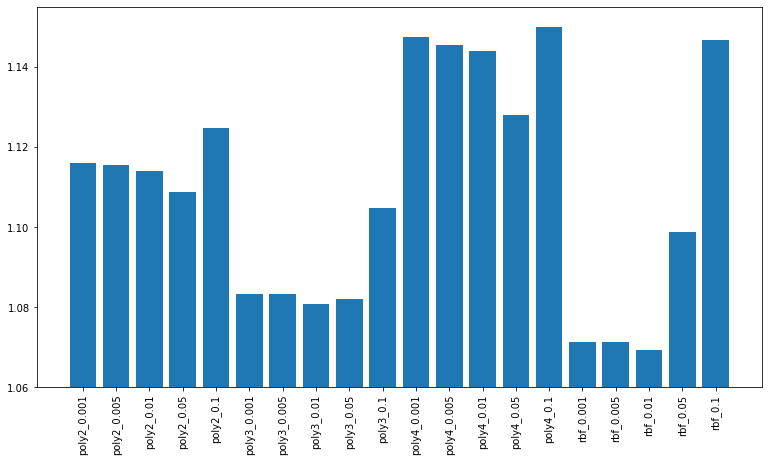

In [ ]:
df = pd.concat([pd.read_csv(base_path+'Models/svr/svr_livello_offset'+str(offset)+'_hyperparameters.csv') for offset in tmp_offsets])
df = df.groupby(['name']).mean().reset_index()
plt.bar(df['name'], df['mae'])
plt.xticks(rotation=90)
plt.ylim([1.06, 1.155])
plt.show();

salvo modelli per ogni combinazione offset - prev, e salvo MAE sul val set di ognuno

In [ ]:
rows = []

for offset in offsets:
  row = []
  for prev in prevs:
    # read files
    X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, prev, offset)

    # reshape
    X_train = X_train.reshape(len(X_train),-1)
    X_val = X_val.reshape(len(X_val),-1)
    X_test = X_test.reshape(len(X_test),-1)

    # model
    svr = SVR(kernel='rbf', C=1, epsilon=0.01)

    # fit
    svr.fit(X_train, y_train.ravel())

    joblib.dump(svr, base_path+'Models/svr/svr_offset'+str(offset)+'_prev'+str(prev)+'_'+target+'.joblib')

    # make predictions on validation
    y_pred = scaler[target].inverse_transform(svr.predict(X_val).reshape(-1,1))
    y_true = scaler[target].inverse_transform(np.array(y_val).reshape(-1,1))

    # calculate mae on validation
    mae = mean_absolute_error(y_true, y_pred)

    row.append(mae)
  rows.append(row)

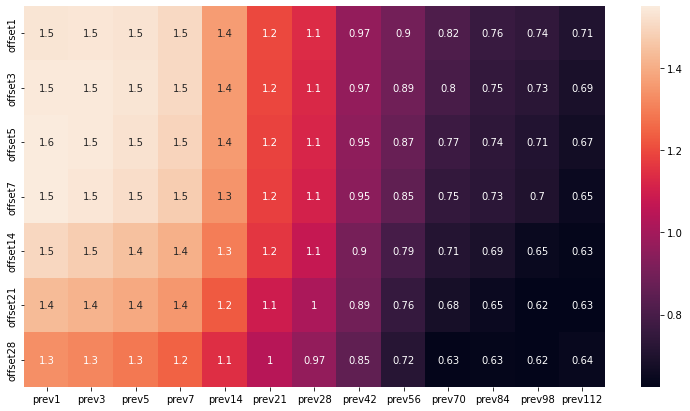

In [ ]:
index = ['offset'+str(o) for o in offsets]
cols = ['prev'+str(p) for p in prevs]
df = pd.DataFrame(rows, columns=cols, index=index)
df.to_csv(base_path+'Models/svr/svr_'+target+'_results.csv', index=False)
sns.heatmap(df, annot=True)

salva 1 modello per ogni offset, con il suo miglior prev


In [ ]:
df = pd.read_csv(base_path+'Models/svr/svr_'+target+'_results.csv')
best_prevs = [int(i[4:]) for i in df.idxmin(axis=1)]
best_prevs_dict = {int(off): int(best_prevs[i]) for i,off in enumerate(offsets)}

print(best_prevs_dict)

for offset in offsets:
  # read files
  X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, best_prevs_dict[offset], offset)
  
  # reshape
  X_train = X_train.reshape(len(X_train),-1)
  X_val = X_val.reshape(len(X_val),-1)
  X_test = X_test.reshape(len(X_test),-1)

  # model
  model = SVR(kernel='rbf', C=1, epsilon=0.01)
  model.fit(X_train, y_train.ravel())
  joblib.dump(model, base_path+'Models/svr/svr_offset'+str(offset)+'_prev'+str(best_prevs_dict[offset])+'_'+target+'.joblib')

{1: 112, 3: 112, 5: 112, 7: 112, 14: 112, 21: 98, 28: 98}


plot line, best MAE for each offset

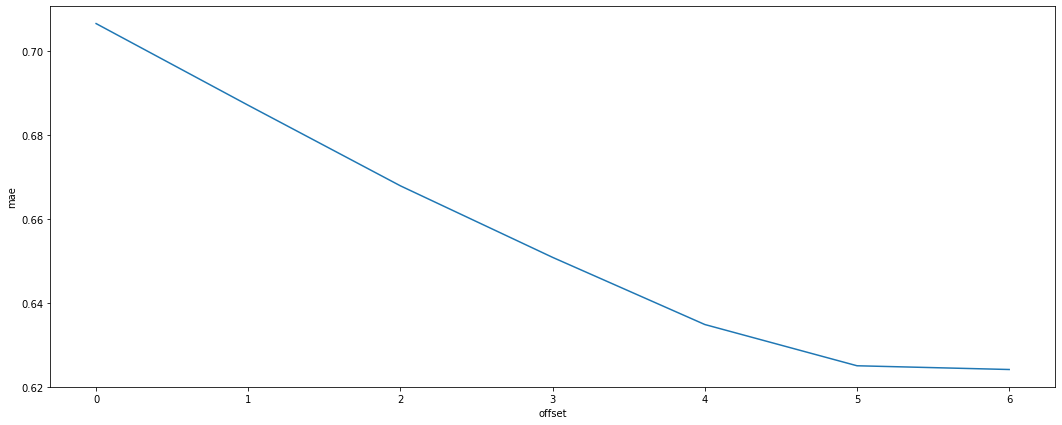

In [ ]:
df_pivot = pd.read_csv(base_path+'Models/svr/rbf_epsilon01_'+target+'.csv')
df = pd.DataFrame(np.min(df_pivot.values, axis=1).reshape(-1,1), columns=['mae'])
df['offset'] = df_pivot.index
sns.lineplot(data=df, x='offset', y='mae')
plt.show();

### SVR portata

ANALISI DEI RISULTATI, VIENE TUTTA BASSA QUINDI VICINA ALLA BASELINE MA NON AZZARDA MAI I PICCHI, RISULTATO è MAE BASSO MA NON HA VALORE

In [ ]:
# y_pred = scaler[target].inverse_transform(svr.predict(X_test).reshape(-1,1))
# y_true = scaler[target].inverse_transform(np.array(y_test).reshape(-1,1))
# plt.plot(y_pred)
# plt.plot(y_true)

In [ ]:
target = 'portata'

In [ ]:
tmp_offsets = [1, 7, 28]
tmp_prevs = [1, 7, 28, 70, 112]
kernels = ['poly', 'rbf']
epsilons = [0.001, 0.005, 0.01, 0.05, 0.1]

tot = []

for offset in tmp_offsets:
  rows = []

  for prev in tmp_prevs:
    row = []
    print(offset, '|', prev)

    # read files
    X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, prev, offset)

    # reshape
    X_train = X_train.reshape(len(X_train),-1)
    X_val = X_val.reshape(len(X_val),-1)
    X_test = X_test.reshape(len(X_test),-1)

    for kernel in kernels:
      
      for epsilon in epsilons:

        for deg in [2, 3, 4]:
          # initialize
          svr = SVR(kernel=kernel, C=1, epsilon=epsilon, degree=deg)

          # fit
          svr.fit(X_train, y_train.ravel())

          # make predictions on validation
          y_pred = scaler[target].inverse_transform(svr.predict(X_val).reshape(-1,1))
          y_true = scaler[target].inverse_transform(np.array(y_val).reshape(-1,1))

          # calculate mae on validation
          mae = mean_absolute_error(y_true, y_pred)
          
          if kernel == 'rbf':
            row.append([kernel+'_'+str(epsilon),int(prev), round(mae, 2)])
            break # do it only with one deg
          else:
            row.append([kernel+str(deg)+'_'+str(epsilon),int(prev), round(mae, 2)])

    rows.append(row)
  tot.append(rows)

1 | 1
1 | 7
1 | 28
1 | 70
1 | 112
7 | 1
7 | 7
7 | 28
7 | 70
7 | 112
28 | 1
28 | 7
28 | 28
28 | 70
28 | 112


In [ ]:
# for i in range(len(tmp_offsets)):
#   offset = tmp_offsets[i]
#   tmp = tot[i]
#   df = pd.DataFrame(np.array(tmp).reshape(20*5, 3), columns=['name', 'prev', 'mae']).round(2)
#   df['mae'] = df['mae'].astype('float64').round(2)
#   df['prev'] =df['prev'].astype('int32')
#   df.to_csv(base_path+'Models/svr/svr_portata_offset'+str(offset)+'_hyperparameters.csv', index=False)

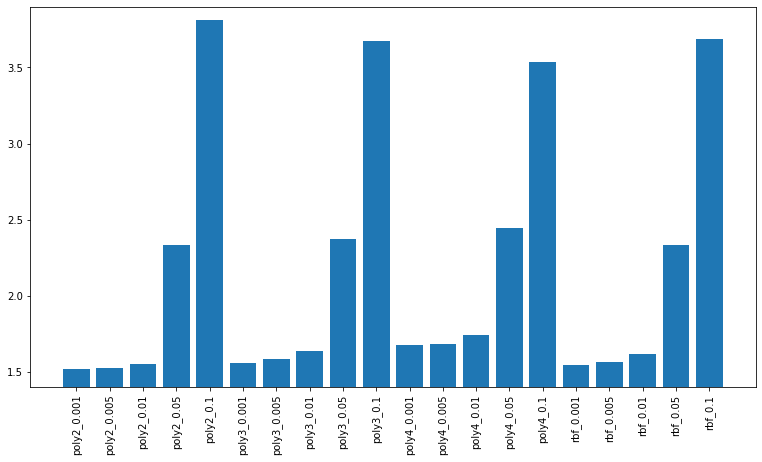

In [ ]:
df = pd.concat([pd.read_csv(base_path+'Models/svr/svr_portata_offset'+str(offset)+'_hyperparameters.csv') for offset in tmp_offsets])
df = df.groupby(['name']).mean().reset_index()
plt.bar(df['name'], df['mae'])
plt.xticks(rotation=90)
plt.ylim([1.4, 3.9])
plt.show();

In [ ]:
rows = []

for offset in offsets:
  row = []
  for prev in prevs:
    print(offset, '|', prev)
    
    # read files
    X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, prev, offset)

    # reshape
    X_train = X_train.reshape(len(X_train),-1)
    X_val = X_val.reshape(len(X_val),-1)
    X_test = X_test.reshape(len(X_test),-1)

    # model
    svr = SVR(kernel='poly', C=1, degree=2, epsilon=0.001)

    # fit
    svr.fit(X_train, y_train.ravel())

    # make predictions on validation
    y_pred = scaler[target].inverse_transform(svr.predict(X_val).reshape(-1,1))
    y_true = scaler[target].inverse_transform(np.array(y_val).reshape(-1,1))

    # calculate mae on validation
    mae = mean_absolute_error(y_true, y_pred)

    row.append(mae)
  rows.append(row)

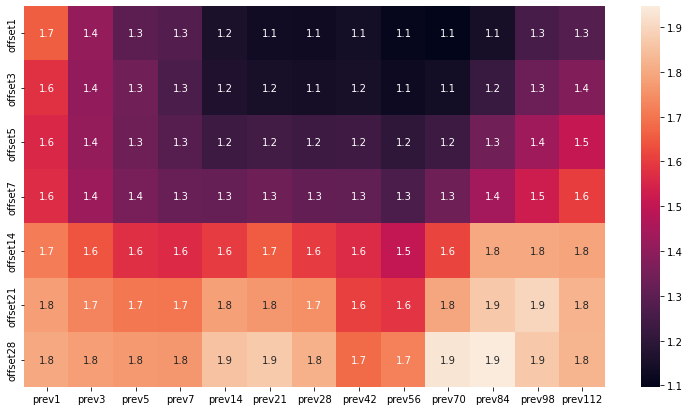

In [ ]:
index = ['offset'+str(o) for o in offsets]
cols = ['prev'+str(p) for p in prevs]
df = pd.DataFrame(rows, columns=cols, index=index)
df.to_csv(base_path+'Models/svr/svr_'+target+'_results.csv', index=False)
sns.heatmap(df, annot=True)

salva 1 modello per ogni offset, con il suo miglior prev

In [ ]:
df = pd.read_csv(base_path+'Models/svr/svr_'+target+'_results.csv')
best_prevs = [int(i[4:]) for i in df.idxmin(axis=1)]
best_prevs_dict = {int(off): int(best_prevs[i]) for i,off in enumerate(offsets)}

print(best_prevs_dict)

for offset in offsets:
  # read files
  X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, best_prevs_dict[offset], offset)
  
  # reshape
  X_train = X_train.reshape(len(X_train),-1)
  X_val = X_val.reshape(len(X_val),-1)
  X_test = X_test.reshape(len(X_test),-1)

  # model
  model = SVR(kernel='poly', C=1, degree=2, epsilon=0.001)
  model.fit(X_train, y_train.ravel())
  joblib.dump(model, base_path+'Models/svr/svr_offset'+str(offset)+'_prev'+str(best_prevs_dict[offset])+'_'+target+'.joblib')

{1: 70, 3: 56, 5: 56, 7: 56, 14: 56, 21: 56, 28: 42}


plot line, best MAE for each offset

In [ ]:
df_pivot = pd.read_csv(base_path+'Models/svr/poly2_epsilon001_'+target+'.csv')
df_pivot = df_pivot.rename(columns={'Unnamed: 0': "name"})
df_pivot = df_pivot.set_index('name')
df = pd.DataFrame(np.min(df_pivot.values, axis=1).reshape(-1,1), columns=['mae'])
df['offset'] = df_pivot.index
sns.lineplot(data=df, x='offset', y='mae')
plt.show();

## KNN

### KNN livello

Quanti K?

In [ ]:
target = 'livello'

In [ ]:
tmp_offsets = [1, 7, 28]
tmp_prevs = [1, 7, 28, 70, 112]
tmp_k = range(10, 61, 2)
errors = [] 

for offset in tmp_offsets:
  print('\n', offset, end=': ')

  for prev in tmp_prevs:
    print(prev, end=', ')

    # read files
    X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, prev, offset)

    # reshape
    X_train = X_train.reshape(len(X_train),-1)
    X_val = X_val.reshape(len(X_val),-1)
    X_test = X_test.reshape(len(X_test),-1)

    for K in tmp_k:
        model = neighbors.KNeighborsRegressor(n_neighbors=K, weights="distance", algorithm='kd_tree') # euclidean distance
        model.fit(X_train, y_train) 

        y_pred = scaler[target].inverse_transform(model.predict(X_val))
        y_true = scaler[target].inverse_transform(np.array(y_val).reshape(-1,1))
        mae = mean_absolute_error(y_true, y_pred)
        errors.append([K, offset, prev, mae]) 


 1: 1, 7, 28, 70, 112, 
 7: 1, 7, 28, 70, 112, 
 28: 1, 7, 28, 70, 112, 

In [ ]:
df = pd.DataFrame(errors, columns=['k', 'offset', 'prev', 'mae'])
df.to_csv(base_path+'Models/knn/knn_'+target+'_hyperparameters.csv', index=False)

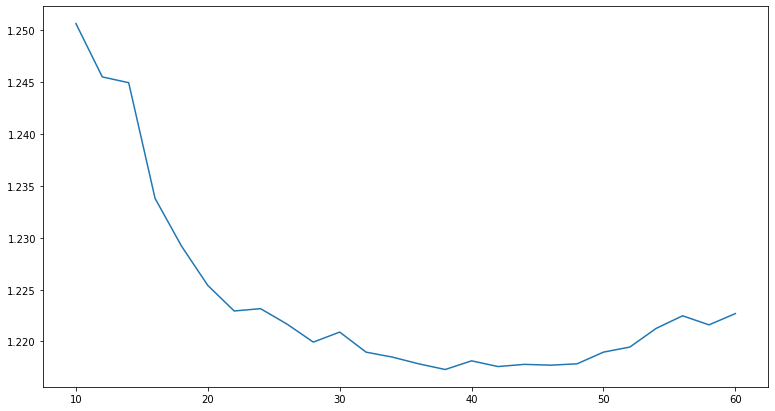

In [ ]:
df = pd.read_csv(base_path+'Models/knn/knn_'+target+'_hyperparameters.csv')
df = df.groupby(['k']).mean().reset_index()
plt.plot(df['k'], df['mae'])
plt.show();

In [ ]:
df.iloc[np.argmin(df['mae'])]

k         38.000000
offset    12.000000
prev      43.600000
mae        1.217296
Name: 14, dtype: float64

In [ ]:
best_k = 38

In [ ]:
rows = []

for offset in offsets:
  row = []
  for prev in prevs:
    # read files
    X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, prev, offset)

    # reshape
    X_train = X_train.reshape(len(X_train),-1)
    X_val = X_val.reshape(len(X_val),-1)
    X_test = X_test.reshape(len(X_test),-1)

    # model
    model = neighbors.KNeighborsRegressor(n_neighbors=best_k, weights="distance", algorithm='kd_tree')
    model.fit(X_train, y_train) 

    # make predictions on validation
    y_pred = scaler[target].inverse_transform(model.predict(X_val).reshape(-1,1))
    y_true = scaler[target].inverse_transform(np.array(y_val).reshape(-1,1))

    # calculate mae on validation
    mae = mean_absolute_error(y_true, y_pred)

    row.append(mae)
  rows.append(row)

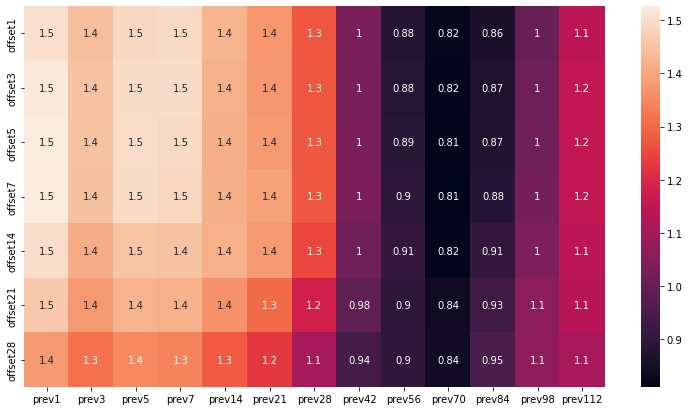

In [ ]:
index = ['offset'+str(o) for o in offsets]
cols = ['prev'+str(p) for p in prevs]
df = pd.DataFrame(rows, columns=cols, index=index)
df.to_csv(base_path+'Models/knn/knn_'+target+'_results.csv', index=False)
sns.heatmap(df, annot=True)

salva 1 modello per ogni offset, con il suo miglior prev

In [ ]:
df = pd.read_csv(base_path+'Models/knn/knn_'+target+'_results.csv')
best_prevs = [int(i[4:]) for i in df.idxmin(axis=1)]
best_prevs_dict = {int(off): int(best_prevs[i]) for i,off in enumerate(offsets)}

print(best_prevs_dict)

for offset in offsets:
  # read files
  X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, best_prevs_dict[offset], offset)
  
  # reshape
  X_train = X_train.reshape(len(X_train),-1)
  X_val = X_val.reshape(len(X_val),-1)
  X_test = X_test.reshape(len(X_test),-1)

  # model
  model = neighbors.KNeighborsRegressor(n_neighbors=best_k, weights="distance", algorithm='kd_tree')
  model.fit(X_train, y_train) 
  joblib.dump(model, base_path+'Models/knn/knn_offset'+str(offset)+'_prev'+str(best_prevs_dict[offset])+'_'+target+'.joblib')

{1: 70, 3: 70, 5: 70, 7: 70, 14: 70, 21: 70, 28: 70}


### KNN portata

In [4]:
target = 'portata'

In [ ]:
tmp_offsets = [1, 7, 28]
tmp_prevs = [1, 7, 28, 70, 112]
tmp_k = range(20, 201, 10)
errors = [] 

for offset in tmp_offsets:
  print('\n', offset, end=': ')
  
  for prev in tmp_prevs:
    print(prev, end=', ')

    # read files
    X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, prev, offset)

    # reshape
    X_train = X_train.reshape(len(X_train),-1)
    X_val = X_val.reshape(len(X_val),-1)
    X_test = X_test.reshape(len(X_test),-1)

    for K in tmp_k:
        model = neighbors.KNeighborsRegressor(n_neighbors=K, weights="distance", algorithm='kd_tree') # euclidean distance
        model.fit(X_train, y_train) 

        y_pred = scaler[target].inverse_transform(model.predict(X_val))
        y_true = scaler[target].inverse_transform(np.array(y_val).reshape(-1,1))
        mae = mean_absolute_error(y_true, y_pred)
        errors.append([K, offset, prev, mae]) 


 1: 1, 7, 28, 70, 112, 
 7: 1, 7, 28, 70, 112, 
 28: 1, 7, 28, 70, 112, 

In [ ]:
df = pd.DataFrame(errors, columns=['k', 'offset', 'prev', 'mae'])
df.to_csv(base_path+'Models/knn/knn_'+target+'_hyperparameters.csv', index=False)

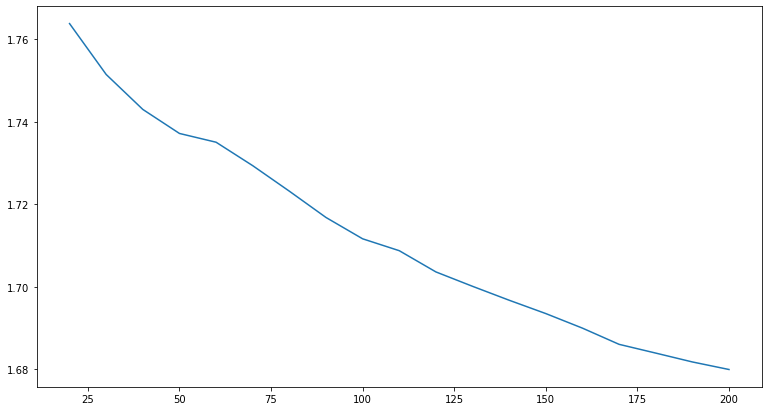

In [ ]:
df = pd.read_csv(base_path+'Models/knn/knn_'+target+'_hyperparameters.csv')
df = df.groupby(['k']).mean().reset_index()
plt.plot(df['k'], df['mae'])
plt.show();

In [ ]:
df.iloc[np.argmin(df['mae'])]

In [ ]:
best_k = 200

In [ ]:
rows = []

for offset in offsets:
  row = []
  for prev in prevs:
    # read files
    X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, prev, offset)

    # reshape
    X_train = X_train.reshape(len(X_train),-1)
    X_val = X_val.reshape(len(X_val),-1)
    X_test = X_test.reshape(len(X_test),-1)

    # model
    model = neighbors.KNeighborsRegressor(n_neighbors=best_k, weights="distance", algorithm='kd_tree')
    model.fit(X_train, y_train) 

    # make predictions on validation
    y_pred = scaler[target].inverse_transform(model.predict(X_val).reshape(-1,1))
    y_true = scaler[target].inverse_transform(np.array(y_val).reshape(-1,1))

    # calculate mae on validation
    mae = mean_absolute_error(y_true, y_pred)

    row.append(mae)
  rows.append(row)

In [14]:
y_preds = []

for kn in [50, 200, 500]:
  for offset in [1]:
    row = []
    for prev in [21]:
      # read files
      X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, prev, offset)

      # reshape
      X_train = X_train.reshape(len(X_train),-1)
      X_val = X_val.reshape(len(X_val),-1)
      X_test = X_test.reshape(len(X_test),-1)

      # model
      model = neighbors.KNeighborsRegressor(n_neighbors=kn, weights="distance", algorithm='kd_tree')
      model.fit(X_train, y_train) 

      # make predictions on validation
      y_pred = scaler[target].inverse_transform(model.predict(X_val).reshape(-1,1))
      y_true = scaler[target].inverse_transform(np.array(y_val).reshape(-1,1))
      y_preds.append(y_pred)

k= 10, 200, 500 and offset = 1, prev = 21

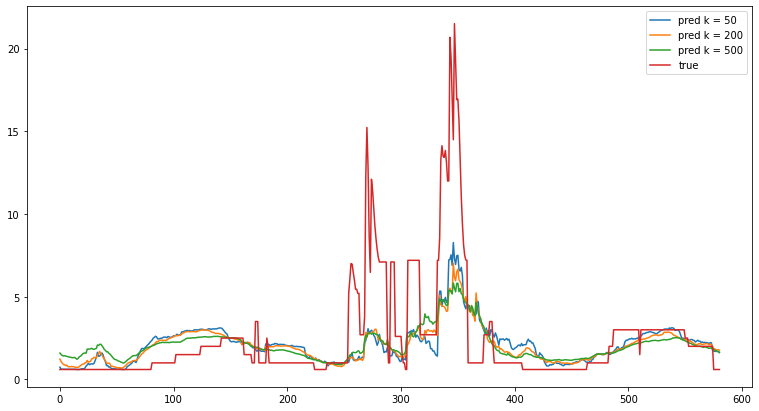

In [15]:
plt.plot(y_preds[0], label='pred k = 50')
plt.plot(y_preds[1], label='pred k = 200')
plt.plot(y_preds[2], label='pred k = 500')
plt.plot(y_true, label='true')
plt.legend()

In [ ]:
rows = []

for offset in offsets:
  row = []
  for prev in prevs:
    # read files
    X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, prev, offset)

    # reshape
    X_train = X_train.reshape(len(X_train),-1)
    X_val = X_val.reshape(len(X_val),-1)
    X_test = X_test.reshape(len(X_test),-1)

    # model
    model = neighbors.KNeighborsRegressor(n_neighbors=50, weights="distance", algorithm='kd_tree')
    model.fit(X_train, y_train) 

    # make predictions on validation
    y_pred = scaler[target].inverse_transform(model.predict(X_val).reshape(-1,1))
    y_true = scaler[target].inverse_transform(np.array(y_val).reshape(-1,1))

    # calculate mae on validation
    mae = mean_absolute_error(y_true, y_pred)

    row.append(mae)
  rows.append(row)

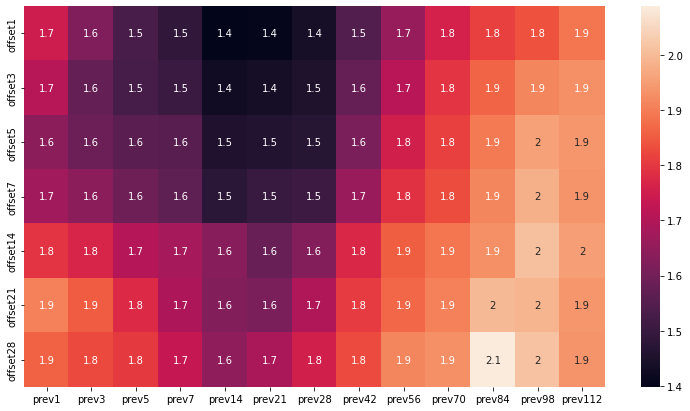

In [ ]:
index = ['offset'+str(o) for o in offsets]
cols = ['prev'+str(p) for p in prevs]
df = pd.DataFrame(rows, columns=cols, index=index)
df.to_csv(base_path+'Models/knn/knn_'+target+'_results50.csv', index=False)
sns.heatmap(df, annot=True)

salva 1 modello per ogni offset, con il suo miglior prev

In [ ]:
df = pd.read_csv(base_path+'Models/knn/knn_'+target+'_results50.csv')
best_prevs = [int(i[4:]) for i in df.idxmin(axis=1)]
best_prevs_dict = {int(off): int(best_prevs[i]) for i,off in enumerate(offsets)}

print(best_prevs_dict)

for offset in offsets:
  # read files
  X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, best_prevs_dict[offset], offset)
  
  # reshape
  X_train = X_train.reshape(len(X_train),-1)
  X_val = X_val.reshape(len(X_val),-1)
  X_test = X_test.reshape(len(X_test),-1)

  # model
  model = neighbors.KNeighborsRegressor(n_neighbors=50, weights="distance", algorithm='kd_tree')
  model.fit(X_train, y_train) 
  joblib.dump(model, base_path+'Models/knn/knn_offset'+str(offset)+'_prev'+str(best_prevs_dict[offset])+'_'+target+'.joblib')

{1: 14, 3: 14, 5: 14, 7: 14, 14: 21, 21: 21, 28: 14}


## VAR

In [ ]:
#https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#riunisco 
train_la_var = X_la_train.copy()
train_la_var['livello'] = y_la_train

test_la_var = X_la_test.copy()
test_la_var['livello'] = y_la_test

df=pd.read_csv(base_path+'Data/Original/Bacino idrico.csv')

df2=df.copy()
del df2["Data"]

In [ ]:
df

,Data,Pioggia_Zona_1,Pioggia_Zona_2,Pioggia_Zona_3,Pioggia_Zona_4,Pioggia_Zona_5,Temperatura_Zona_5,Livello_Acqua,Portata_Uscita
0,06/01/2003,NaN,NaN,NaN,NaN,NaN,NaN,30.70,9.6
1,07/01/2003,NaN,NaN,NaN,NaN,NaN,NaN,30.70,9.5
2,08/01/2003,NaN,NaN,NaN,NaN,NaN,NaN,30.67,9.5
3,09/01/2003,NaN,NaN,NaN,NaN,NaN,NaN,30.66,7.2
4,10/01/2003,NaN,NaN,NaN,NaN,NaN,NaN,30.64,6.2
...,...,...,...,...,...,...,...,...,...
6381,26/06/2020,0.0,0.0,0.0,0.0,0.0,22.50,29.85,0.6
6382,27/06/2020,0.0,0.0,0.0,0.0,0.0,23.40,29.84,0.6
6383,28/06/2020,0.0,0.0,0.0,0.0,0.0,21.50,29.83,0.6
6384,29/06/2020,0.0,0.0,0.0,0.0,0.0,23.20,29.82,0.6


In [ ]:
df.columns = ['data','p1', 'p2', 'p3', 'p4', 'p5', 't5', 'livello', 'portata']
df["data"] = pd.to_datetime(df["data"], format='%d/%m/%Y')
df.set_index("data", inplace=True)
df.loc['2004-01-01', 't5'] = 8.0 
df = df['2004-01-02':]

df

,p1,p2,p3,p4,p5,t5,livello,portata
data,,,,,,,,
2004-01-02,0.0,0.0,0.0,0.0,0.0,6.50,30.21,0.5
2004-01-03,0.0,0.0,0.0,0.0,0.0,4.45,30.28,0.5
2004-01-04,0.0,0.0,0.0,0.0,0.0,2.00,30.35,0.5
2004-01-05,0.2,0.0,0.0,0.0,0.0,0.90,30.37,0.5
2004-01-06,0.0,0.0,0.0,0.0,0.0,2.25,30.42,0.5
...,...,...,...,...,...,...,...,...
2020-06-26,0.0,0.0,0.0,0.0,0.0,22.50,29.85,0.6
2020-06-27,0.0,0.0,0.0,0.0,0.0,23.40,29.84,0.6
2020-06-28,0.0,0.0,0.0,0.0,0.0,21.50,29.83,0.6


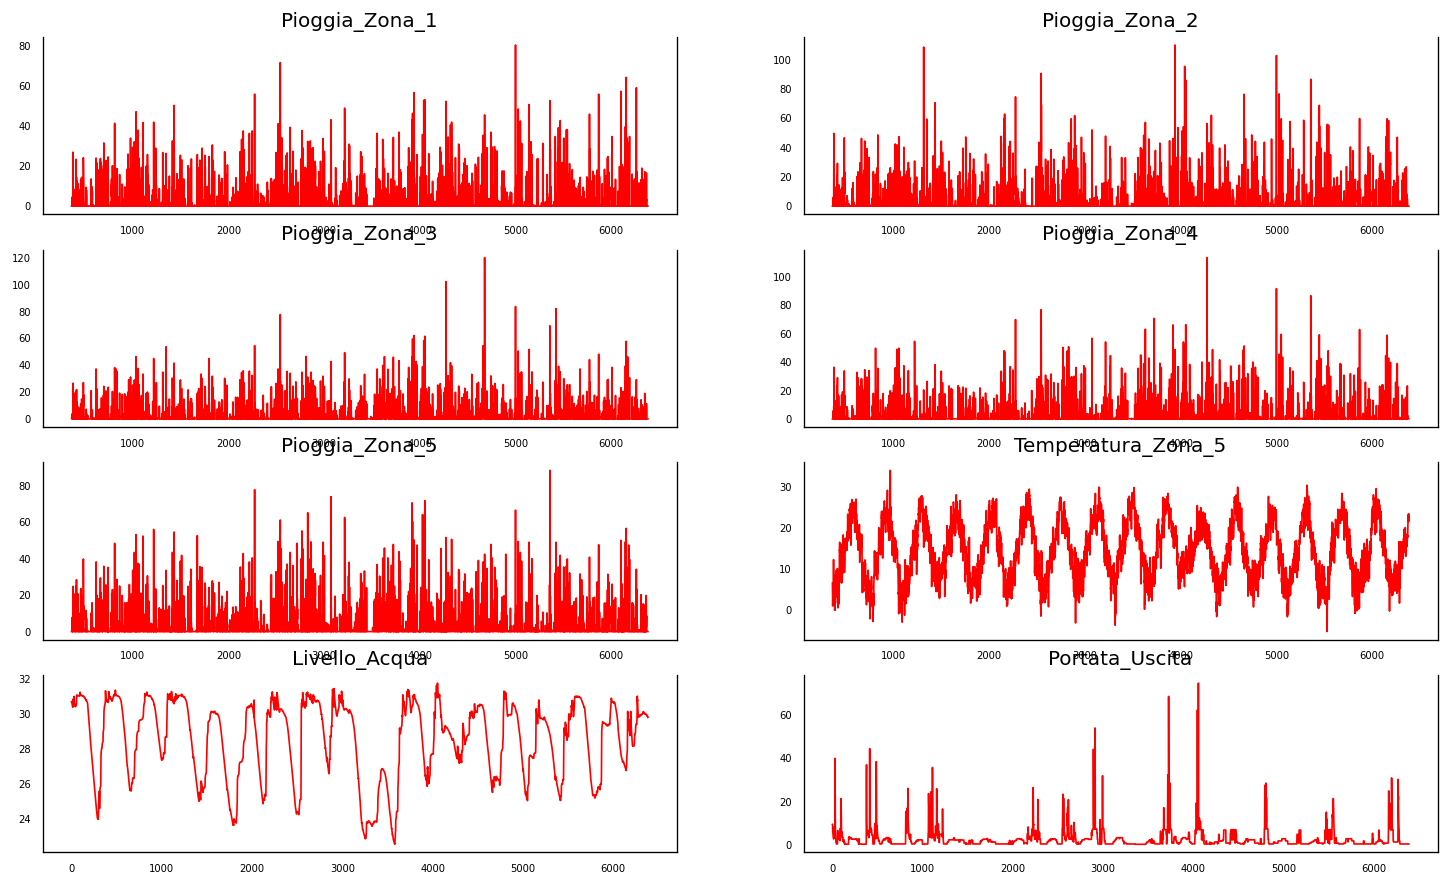

In [ ]:
# Plot

fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(15,9))
for i, ax in enumerate(axes.flatten()):
      data = df2[df2.columns[i]]
      ax.plot(data, color='red', linewidth=1)
      # Decorations
      ax.set_title(df2.columns[i])
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)

In [ ]:
nobs = 1000
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (5386, 8)
print(df_test.shape)  # (1000), 8)

(5025, 8)
(1000, 8)


In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [ ]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "p1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -20.6873
 No. Lags Chosen       = 8
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "p2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -19.4157
 No. Lags Chosen       = 9
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "p3" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Tes

In [ ]:
#sembra già stazionaria , non differenzio
# 1st difference
#df_differenced = train_la_var.diff().dropna()

#select order P of VAR model
model = VAR(df_train)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Lag Order = 1
AIC :  10.2345922544038
BIC :  10.328060145125667
FPE :  27850.112506117286
HQIC:  10.2673433377727 

Lag Order = 2
AIC :  10.063076532708417
BIC :  10.239656751611465
FPE :  23460.57752796579
HQIC:  10.124950741238859 

Lag Order = 3
AIC :  9.977662619530768
BIC :  10.237383190606735
FPE :  21539.920878851113
HQIC:  10.068670360274721 

Lag Order = 4
AIC :  9.965393769507768
BIC :  10.308282731976034
FPE :  21277.2835738034
HQIC:  10.085545455337641 

Lag Order = 5
AIC :  9.962089372044515
BIC :  10.388174780363427
FPE :  21207.120518535023
HQIC:  10.11139542165758 

Lag Order = 6
AIC :  9.962172848271567
BIC :  10.471482772149777
FPE :  21208.934518976832
HQIC:  10.140643686194363 

Lag Order = 7
AIC :  9.96705895933479
BIC :  10.559621483742607
FPE :  21312.87814584105
HQIC:  10.17470501592755 

Lag Order = 8
AIC :  9.97063159133511
BIC :  10.646474816515859
FPE :  21389.238295376508
HQIC:  10.20746330279619 

Lag Order = 9
AIC :  9.974156627184612
BIC :  10.7333086686

In [ ]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,20.86,20.87,1.144e+09,20.86
1,10.25,10.34,2.827e+04,10.28
2,10.08,10.25,2.378e+04,10.14
3,9.991,10.25*,2.182e+04,10.08*
4,9.977,10.32,2.153e+04,10.10
5,9.972,10.40,2.142e+04,10.12
6,9.971,10.48,2.139e+04,10.15
7,9.974,10.57,2.147e+04,10.18
8,9.976,10.65,2.151e+04,10.21
9,9.979,10.74,2.156e+04,10.24


In [ ]:
#train var model di 0? boh provo
model_fitted = model.fit(5)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 26, May, 2022
Time:                     14:12:01
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    10.3882
Nobs:                     5020.00    HQIC:                   10.1114
Log likelihood:          -81661.4    FPE:                    21207.1
AIC:                      9.96209    Det(Omega_mle):         19871.0
--------------------------------------------------------------------
Results for equation p1
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              5.316938         1.231703            4.317           0.000
L1.p1              0.151799         0.042448            3.576           0.000
L1.p2              0.157261         0.022931            6.858           0.0

In [ ]:
#guardo correlazione dei residui con durbin watson
from statsmodels.stats.stattools import durbin_watson
def adjust(val, length= 6): return str(val).ljust(length)

out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

p1     : 2.0
p2     : 2.0
p3     : 2.0
p4     : 2.0
p5     : 2.0
t5     : 2.01
livello : 2.01
portata : 2.01


In [ ]:
#The serial correlation seems quite alright. Let’s proceed with the forecast.

# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_train.values[-lag_order:]
forecast_input

5


array([[ 0.4 ,  0.  ,  0.2 ,  0.  ,  0.8 , 13.5 , 25.87,  1.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , 17.35, 25.85,  1.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , 14.5 , 25.82,  2.5 ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , 18.95, 25.79,  2.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , 16.45, 25.75,  1.  ]])

In [ ]:
df_train

,p1,p2,p3,p4,p5,t5,livello,portata
data,,,,,,,,
2004-01-02,0.0,0.0,0.0,0.0,0.0,6.50,30.21,0.5
2004-01-03,0.0,0.0,0.0,0.0,0.0,4.45,30.28,0.5
2004-01-04,0.0,0.0,0.0,0.0,0.0,2.00,30.35,0.5
2004-01-05,0.2,0.0,0.0,0.0,0.0,0.90,30.37,0.5
2004-01-06,0.0,0.0,0.0,0.0,0.0,2.25,30.42,0.5
...,...,...,...,...,...,...,...,...
2017-09-30,0.4,0.0,0.2,0.0,0.8,13.50,25.87,1.0
2017-10-01,0.0,0.0,0.0,0.0,0.0,17.35,25.85,1.0
2017-10-02,0.0,0.0,0.0,0.0,0.0,14.50,25.82,2.5


In [ ]:

# Forecast

fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_forecast')
df_forecast

,p1_forecast,p2_forecast,p3_forecast,p4_forecast,p5_forecast,t5_forecast,livello_forecast,portata_forecast
data,,,,,,,,
2017-10-05,2.372639,3.071690,2.572801,2.607982,2.987588,15.995451,25.719376,0.780363
2017-10-06,1.995589,2.610877,2.201857,2.246008,2.653809,15.788927,25.701725,0.826721
2017-10-07,2.636127,3.519480,2.970789,2.736352,3.047278,15.629444,25.692449,0.921666
2017-10-08,2.458247,3.404056,2.790211,2.881366,3.326757,15.669687,25.684879,1.005465
2017-10-09,2.506310,3.500818,2.779386,2.835020,3.226669,15.573974,25.682222,1.015395
...,...,...,...,...,...,...,...,...
2020-06-26,2.410636,3.329630,2.689339,2.677566,3.143075,14.596302,28.374354,2.767874
2020-06-27,2.410635,3.329629,2.689339,2.677566,3.143075,14.596305,28.374353,2.767873
2020-06-28,2.410635,3.329629,2.689339,2.677566,3.143074,14.596308,28.374352,2.767872


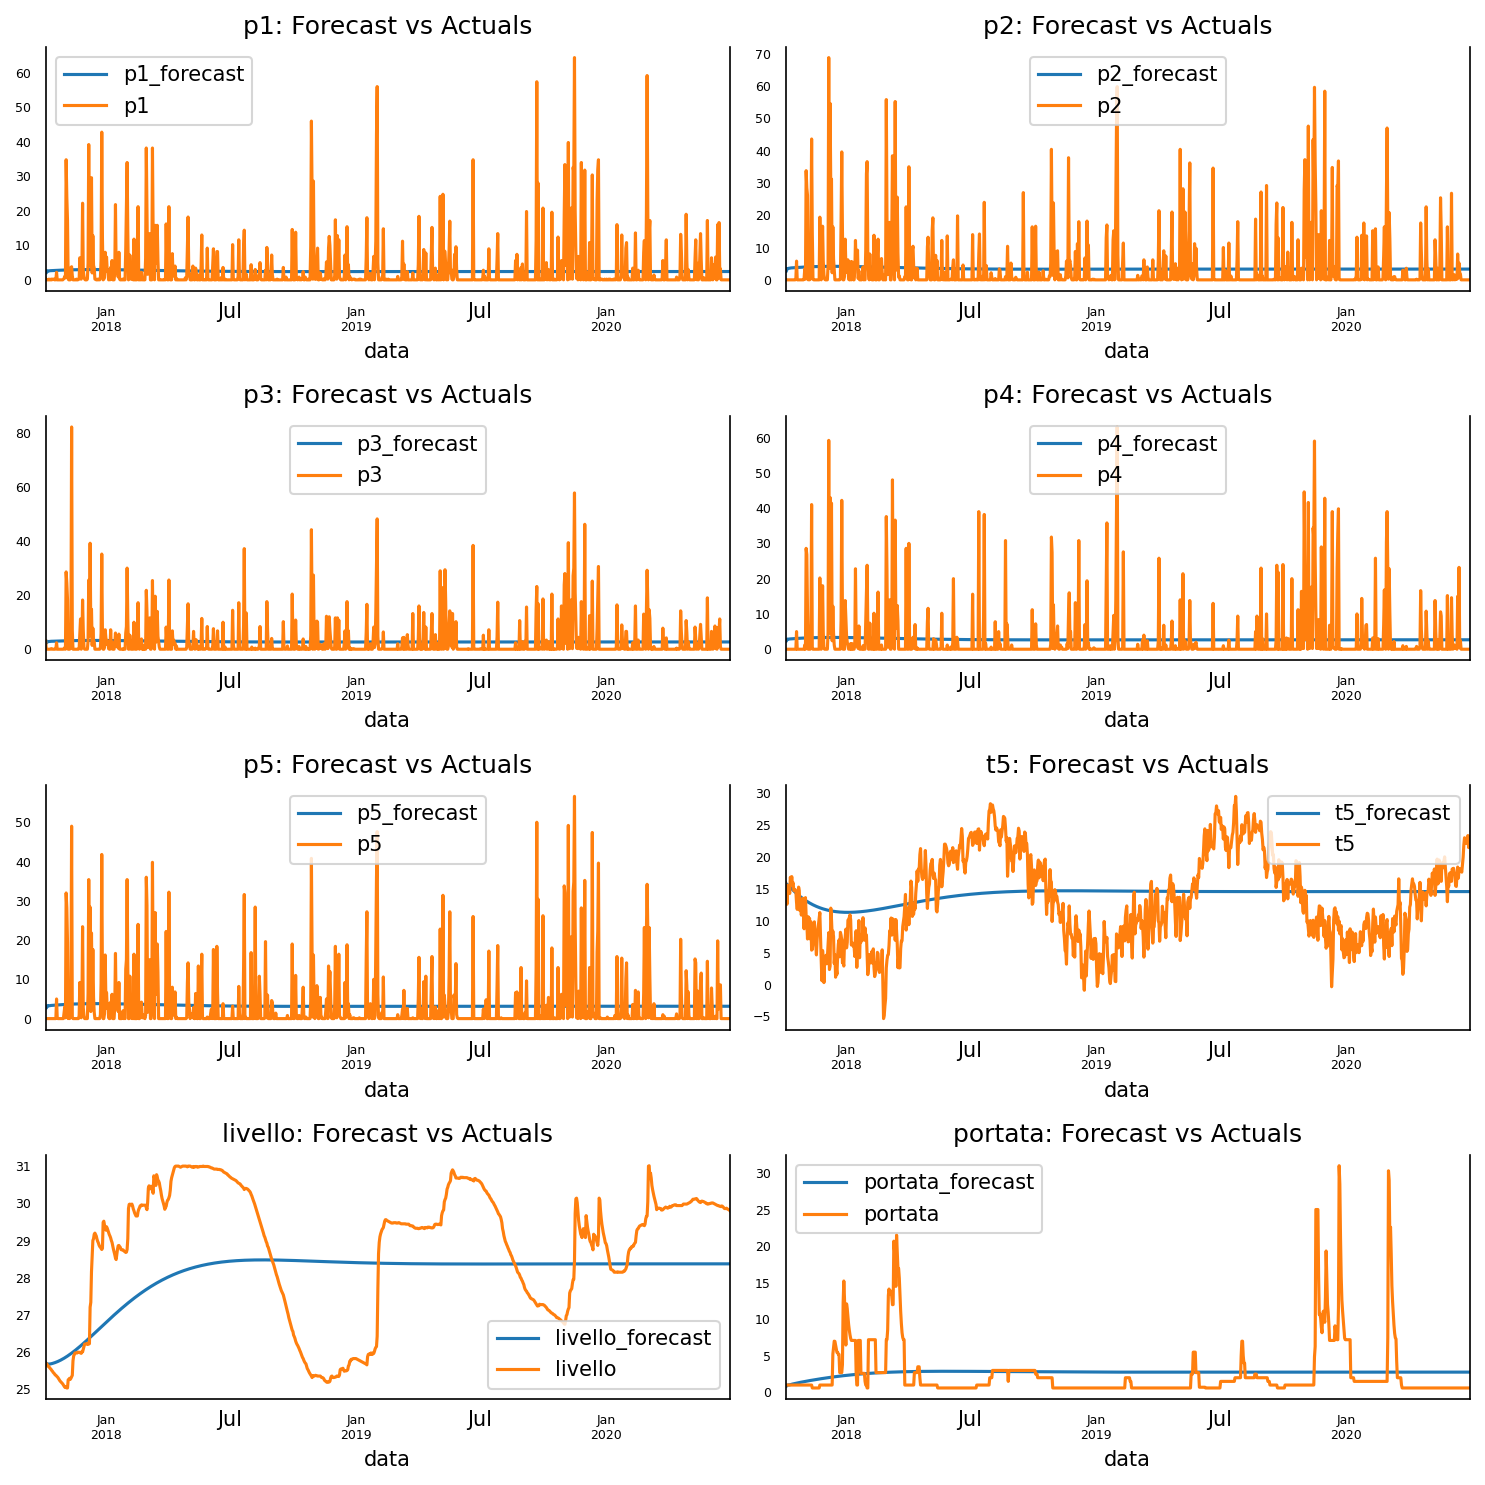

In [ ]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_forecast[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
#evaluate forecasts
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: rgnp')
accuracy_prod = forecast_accuracy(df_forecast['p1_forecast'].values, df_test['p1'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: pgnp')
accuracy_prod = forecast_accuracy(df_forecast['p2_forecast'].values, df_test['p2'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: ulc')
accuracy_prod = forecast_accuracy(df_forecast['p3_forecast'].values, df_test['p3'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfco')
accuracy_prod = forecast_accuracy(df_forecast['p4_forecast'].values, df_test['p4'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdf')
accuracy_prod = forecast_accuracy(df_forecast['p5_forecast'].values, df_test['p5'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfim')
accuracy_prod = forecast_accuracy(df_forecast['t5_forecast'].values, df_test['t5'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfcf')
accuracy_prod = forecast_accuracy(df_forecast['portata_forecast'].values, df_test['portata'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfce')
accuracy_prod = forecast_accuracy(df_forecast['livello_forecast'].values, df_test['livello'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: rgnp
mape   :  inf
me     :  -0.4669
mae    :  4.0457
mpe    :  inf
rmse   :  7.5052
corr   :  0.077
minmax :  0.8591

Forecast Accuracy of: pgnp
mape   :  inf
me     :  -0.2156
mae    :  5.228
mpe    :  inf
rmse   :  8.9103
corr   :  0.1243
minmax :  0.8621

Forecast Accuracy of: ulc
mape   :  inf
me     :  0.0132
mae    :  4.0308
mpe    :  inf
rmse   :  7.0359
corr   :  0.0737
minmax :  0.8577

Forecast Accuracy of: gdfco
mape   :  inf
me     :  -0.1013
mae    :  4.4029
mpe    :  inf
rmse   :  8.016
corr   :  0.0989
minmax :  0.8916

Forecast Accuracy of: gdf
mape   :  inf
me     :  -0.0367
mae    :  4.7476
mpe    :  inf
rmse   :  7.7884
corr   :  0.1051
minmax :  0.8617

Forecast Accuracy of: gdfim
mape   :  1.3822
me     :  0.6604
mae    :  5.6868
mpe    :  0.8972
rmse   :  6.6906
corr   :  0.3572
minmax :  0.3456

Forecast Accuracy of: gdfcf
mape   :  1.8985
me     :  0.0978
mae    :  2.463
mpe    :  1.6813
rmse   :  4.0465
corr   :  0.0277
minmax :  0.5776



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


In [ ]:
#MIGLIORAMENTI

#NORMALIZZARE /STANDARDIZZARE
#FARE DIFFERENZAZIONI
#USARE ANCHE IL 2003 di livello e portata
#SISTEMARE PARAMETRI MODELLO

## Linear *regression*

In [ ]:
# importing module
from sklearn.linear_model import LinearRegression
# creating an object of LinearRegression class
LR = LinearRegression()
# fitting the training data
LR.fit(X_la_train,y_la_train)

LinearRegression()

In [ ]:
y_prediction =  LR.predict(X_la_test)
y_prediction

array([ 1.19435305, -0.14523634, -0.43531676, ..., -0.03212852,
        0.05145754, -0.47737799])

In [ ]:
# importing r2_score module
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# predicting the accuracy score
score=r2_score(y_la_test,y_prediction)
print('r2 score is ',score)
print('mean_sqrd_error is==',mean_squared_error(y_la_test,y_prediction))
print('root_mean_squared error of is==',np.sqrt(mean_squared_error(y_la_test,y_prediction)))

r2 score is  0.10343363782060455
mean_sqrd_error is== 0.9463998582124902
root_mean_squared error of is== 0.9728308476875567


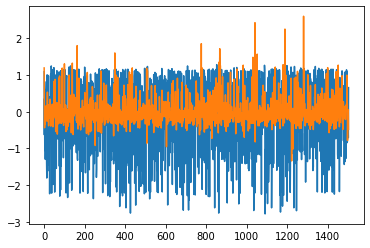

In [ ]:
plt.plot(y_la_test,label="original")
plt.plot(y_prediction,label='predcition')
plt.show()

## NN

### Setup

In [5]:
def get_network(input_shape):
  model = models.Sequential()
  model.add(layers.Dense(512, input_shape=(input_shape,)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(1, activation='linear'))
  return model


def test_prevs_by_offset(target, prevs, offset, executions):
  histories = {}
  val_mae = []
  best_mae = 99999
  best_prev = None

  for prev in prevs:

    # read files
    X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, prev, 7)
    
    # reshape
    X_train = X_train.reshape(len(X_train),-1)
    X_val = X_val.reshape(len(X_val),-1)
    X_test = X_test.reshape(len(X_test),-1)

    tmp = []

    for ex in range(executions):

      model = get_network(X_train.shape[1])

      # compile network
      model.compile(loss=loss, optimizer=optimizer)

      # fit network
      model.fit(X_train, y_train, 
                epochs=epochs, batch_size=batch_size, 
                validation_data=(X_val, y_val), 
                callbacks=[stop_callback], 
                verbose=0)

      # make predictions
      y_pred = scaler[target].inverse_transform(model.predict(X_val))
      y_true = scaler[target].inverse_transform(np.array(y_val).reshape(-1,1))
      mae = mean_absolute_error(y_true, y_pred)
      tmp.append(mae)

    # save best model
    if np.mean(tmp) < best_mae:
      best_mae = np.mean(tmp)
      best_prev = prev

    val_mae.append(tmp)
    print(prev, end=' | ')
  
  return best_prev, val_mae


def test_every_prev_offset(target, prevs, offsets, executions):
  best_prevs = []
  val_maes = []
  for offset in offsets:
    best_prev, val_mae = test_prevs_by_offset(target, prevs=prevs, offset=offset, executions=executions)
    best_prevs.append(best_prev)
    val_maes.append(val_mae)
    print('\noffset', offset, 'done!\n')
  return best_prevs, val_maes

In [6]:
epochs = 100
batch_size = 16
loss = 'mse'
optimizer = tf.keras.optimizers.Adam(1e-4)
stop_callback = callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=3)
executions = 3

### test sulla struttura della rete

In [ ]:
def get_network_small(input_shape):
  model = models.Sequential()
  model.add(layers.Dense(128, input_shape=(input_shape,)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(1, activation='linear'))
  return model

def get_network_medium(input_shape):
  model = models.Sequential()
  model.add(layers.Dense(256, input_shape=(input_shape,)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(1, activation='linear'))
  return model

def get_network_big(input_shape):
  model = models.Sequential()
  model.add(layers.Dense(512, input_shape=(input_shape,)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(1, activation='linear'))
  return model


def try_model(model, X_train, y_train, X_val, y_val, executions):
  errors = []
  for i in range(executions):
    model.compile(loss=loss, optimizer=optimizer)
    model.fit(X_train, y_train, 
              epochs=epochs, batch_size=batch_size, 
              validation_data=(X_val, y_val), 
              callbacks=[stop_callback], 
              verbose=0)
    y_pred = scaler[target].inverse_transform(model.predict(X_val))
    y_true = scaler[target].inverse_transform(np.array(y_val).reshape(-1,1))
    errors.append(mean_absolute_error(y_true, y_pred))
  return np.mean(errors)

In [ ]:
results = {
    'livello': {'small': [], 'medium': [], 'big': []}, 
    'portata': {'small': [], 'medium': [], 'big': []}
}

tmp_offsets = offsets[::3] # cioè [1, 7, 28]
tmp_prevs = prevs[::3] # cioè [1, 7, 28, 70, 112]

for target in targets:
  print('---', target)

  for offset in tmp_offsets:
    res_small = []
    res_medium = []
    res_big = []
    
    for prev in tmp_prevs:
      X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, prev, offset)

      X_train = X_train.reshape(len(X_train),-1)
      X_val = X_val.reshape(len(X_val),-1)
      X_test = X_test.reshape(len(X_test),-1)

      model = get_network_small(X_train.shape[1])
      mae = try_model(model, X_train, y_train, X_val, y_val, executions)
      res_small.append(mae)

      model = get_network_medium(X_train.shape[1])
      mae = try_model(model, X_train, y_train, X_val, y_val, executions)
      res_medium.append(mae)

      model = get_network_big(X_train.shape[1])
      mae = try_model(model, X_train, y_train, X_val, y_val, executions)
      res_big.append(mae)

    results[target]['small'].append(res_small)
    results[target]['medium'].append(res_medium)
    results[target]['big'].append(res_big)
    
    print('offset', offset, 'done!')

--- livello
offset 1 done!
offset 7 done!
offset 28 done!
--- portata
offset 1 done!
offset 7 done!
offset 28 done!


In [ ]:
joblib.dump(results, base_path+'results_prova_struttura.joblib')

['/content/drive/MyDrive/industrylab/results_prova_struttura.joblib']

In [ ]:
results = joblib.load(base_path+'results_prova_struttura.joblib')
tmp_offsets = offsets[::3] # cioè [1, 7, 28]
tmp_prevs = prevs[::3] # cioè [1, 7, 28, 70, 112]

livello


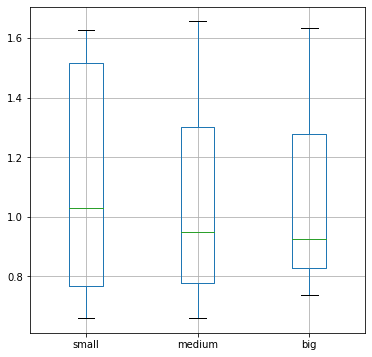

portata


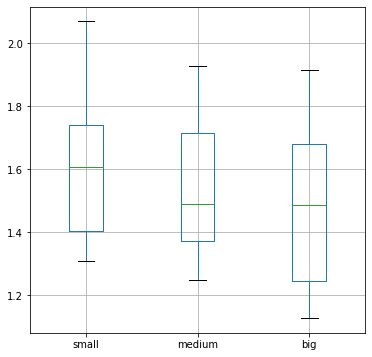

In [ ]:
plt.rcParams["figure.figsize"] = (6,6)

for target in targets:
  print(target)
  s = np.array(results[target]['small']).reshape(-1)
  m = np.array(results[target]['medium']).reshape(-1)
  l = np.array(results[target]['big']).reshape(-1)
  pd.DataFrame([s,m,l], index=['small', 'medium', 'big']).T.boxplot()
  plt.show();

### NN livello

In [ ]:
target = 'livello'

In [ ]:
best_prevs, val_maes = test_every_prev_offset(target, prevs, offsets, executions=executions)
avg_val_maes = [list(np.mean(v, axis=1)) for v in val_maes]

1 | 3 | 5 | 7 | 14 | 21 | 28 | 42 | 56 | 70 | 84 | 98 | 112 | 
offset 1 done!

1 | 3 | 5 | 7 | 14 | 21 | 28 | 42 | 56 | 70 | 84 | 98 | 112 | 
offset 3 done!

1 | 3 | 5 | 7 | 14 | 21 | 28 | 42 | 56 | 70 | 84 | 98 | 112 | 
offset 5 done!

1 | 3 | 5 | 7 | 14 | 21 | 28 | 42 | 56 | 70 | 84 | 98 | 112 | 
offset 7 done!

1 | 3 | 5 | 7 | 14 | 21 | 28 | 42 | 56 | 70 | 84 | 98 | 112 | 
offset 14 done!

1 | 3 | 5 | 7 | 14 | 21 | 28 | 42 | 56 | 70 | 84 | 98 | 112 | 
offset 21 done!

1 | 3 | 5 | 7 | 14 | 21 | 28 | 42 | 56 | 70 | 84 | 98 | 112 | 
offset 28 done!



In [ ]:
best_prevs_dict = {int(off): int(best_prevs[i]) for i,off in enumerate(offsets)}

with open(base_path+'Models/nn/nn_'+target+'_best_prevs.json', 'w') as f:
    json.dump(best_prevs_dict, f)

best_prevs_dict

{1: 98, 3: 98, 5: 112, 7: 98, 14: 98, 21: 98, 28: 98}

OFFSET 1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


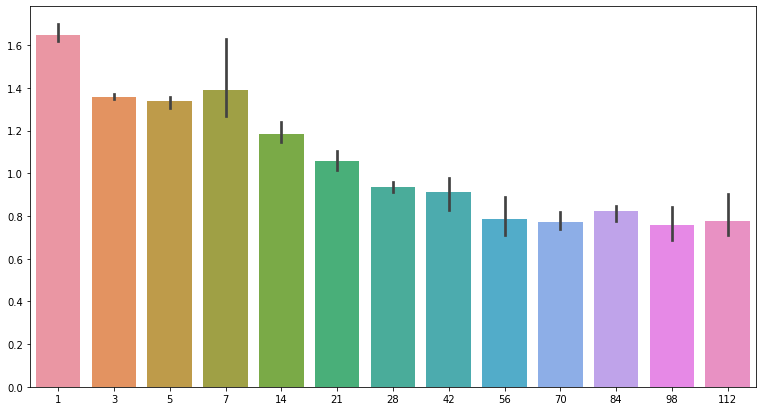

OFFSET 3


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


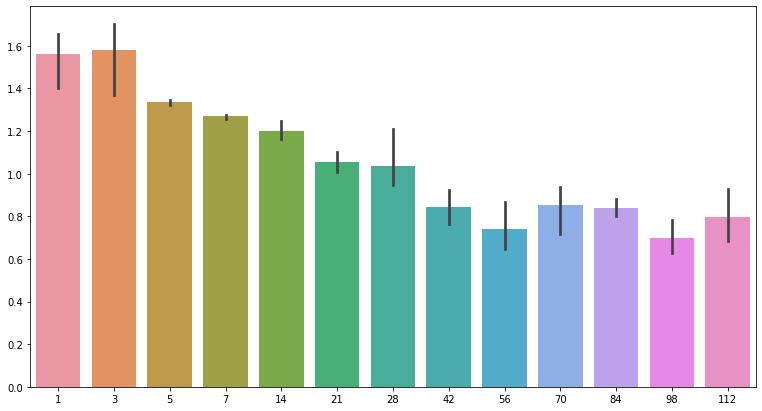

OFFSET 5


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


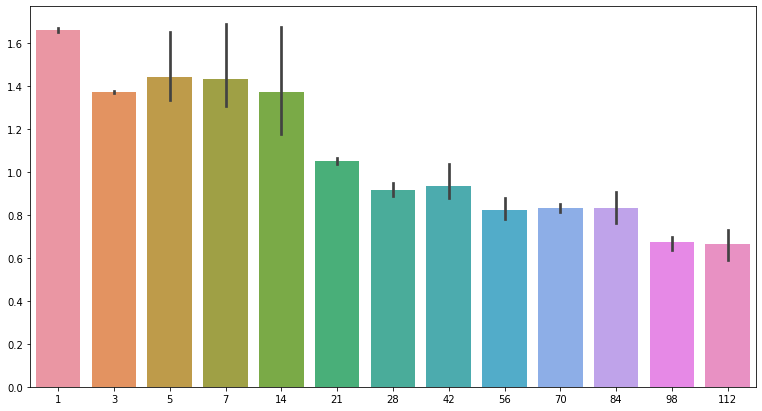

OFFSET 7


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


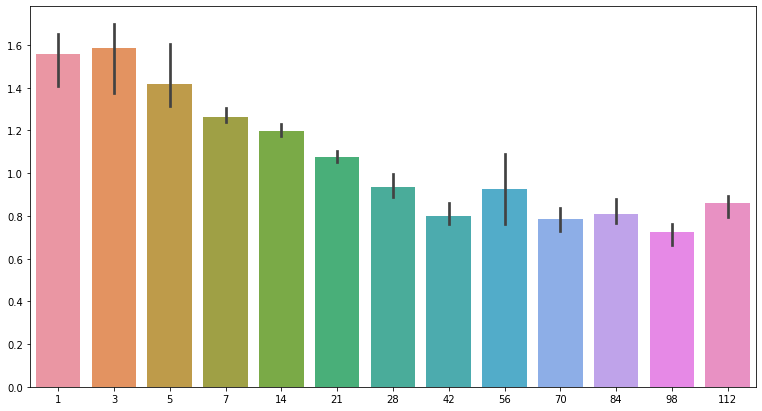

OFFSET 14


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


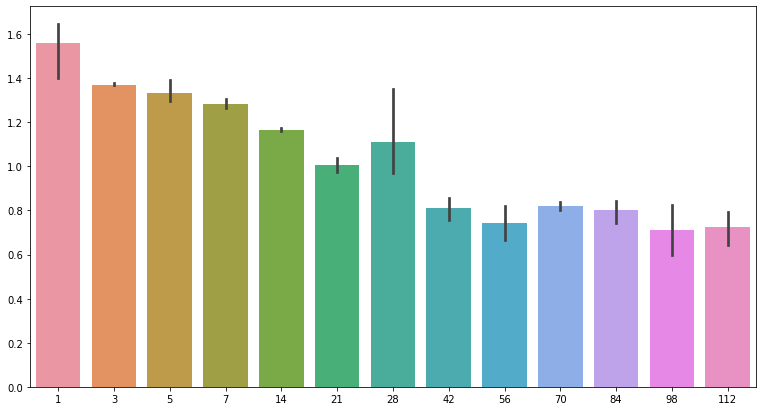

OFFSET 21


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


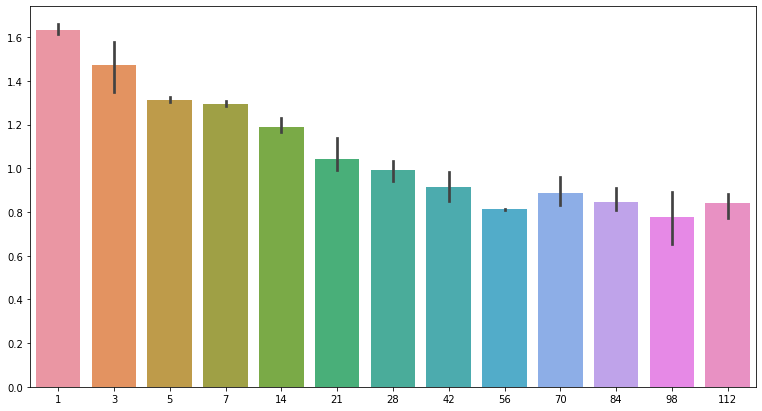

OFFSET 28


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


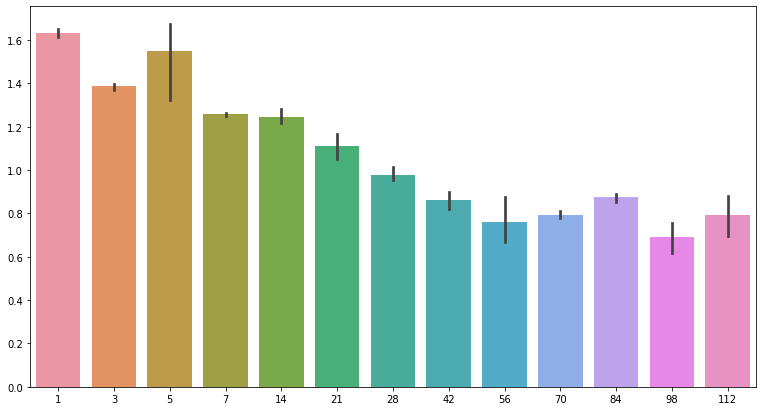

In [ ]:
for i,off in enumerate(offsets):
  print('OFFSET', off)
  x = [item for sublist in val_maes[i] for item in sublist]
  y = np.repeat([[e] for e in prevs], executions, axis=1)
  y = [item for sublist in y for item in sublist]
  sns.barplot(y, x)
  plt.show();

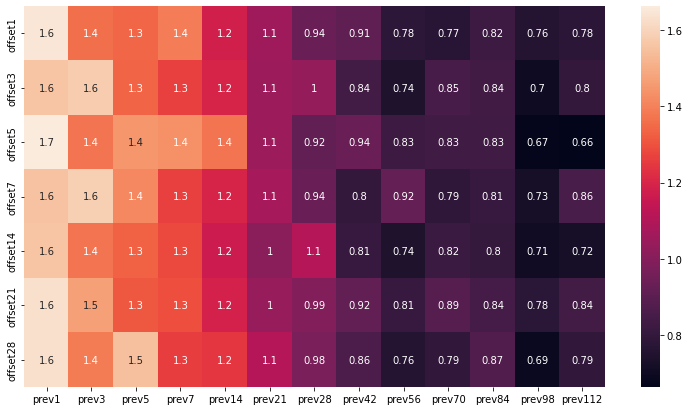

In [ ]:
index = ['offset'+str(o) for o in offsets]
cols = ['prev'+str(p) for p in prevs]
df = pd.DataFrame(avg_val_maes, index=index, columns=cols)
sns.heatmap(df, annot=True)

In [ ]:
for i,off in enumerate(offsets):
  X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, best_prevs[i], off)
  
  X_train = X_train.reshape(len(X_train),-1)
  X_val = X_val.reshape(len(X_val),-1)
  X_test = X_test.reshape(len(X_test),-1)

  model = get_network(X_train.shape[1])
  model.compile(loss=loss, optimizer=optimizer)
  model.fit(X_train, y_train, 
            epochs=epochs, batch_size=batch_size, 
            validation_data=(X_val, y_val), 
            callbacks=[stop_callback], 
            verbose=0)
  model.save(base_path+'Models/nn/model_'+target+'_offset'+str(off))

### NN portata

In [4]:
target = 'portata'

In [ ]:
best_prevs, val_maes = test_every_prev_offset(target, prevs, offsets, executions=executions)
avg_val_maes = [list(np.mean(v, axis=1)) for v in val_maes]

1 | 3 | 5 | 7 | 14 | 21 | 28 | 42 | 56 | 70 | 84 | 98 | 112 | 
offset 1 done!

1 | 3 | 5 | 7 | 14 | 21 | 28 | 42 | 56 | 70 | 84 | 98 | 112 | 
offset 3 done!

1 | 3 | 5 | 7 | 14 | 21 | 28 | 42 | 56 | 70 | 84 | 98 | 112 | 
offset 5 done!

1 | 3 | 5 | 7 | 14 | 21 | 28 | 42 | 56 | 70 | 84 | 98 | 112 | 
offset 7 done!

1 | 3 | 5 | 7 | 14 | 21 | 28 | 42 | 56 | 70 | 84 | 98 | 112 | 
offset 14 done!

1 | 3 | 5 | 7 | 14 | 21 | 28 | 42 | 56 | 70 | 84 | 98 | 112 | 
offset 21 done!

1 | 3 | 5 | 7 | 14 | 21 | 28 | 42 | 56 | 70 | 84 | 98 | 112 | 
offset 28 done!



In [ ]:
best_prevs_dict = {int(off): int(best_prevs[i]) for i,off in enumerate(offsets)}

with open(base_path+'Models/nn/nn_'+target+'_best_prevs.json', 'w') as f:
    json.dump(best_prevs_dict, f)

best_prevs_dict

{1: 21, 3: 14, 5: 21, 7: 28, 14: 21, 21: 5, 28: 14}

OFFSET 1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


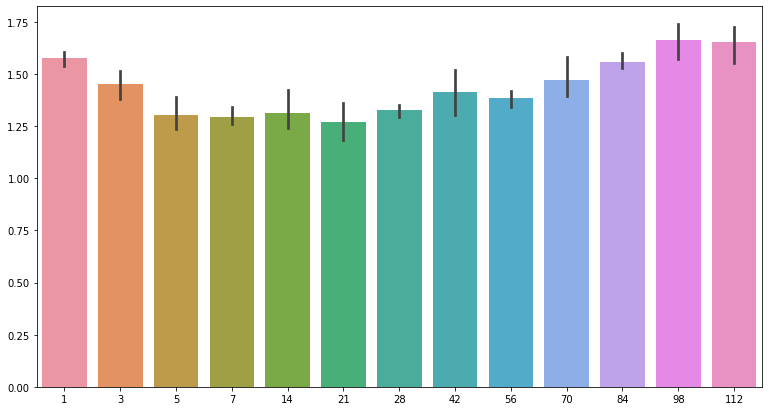

OFFSET 3


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


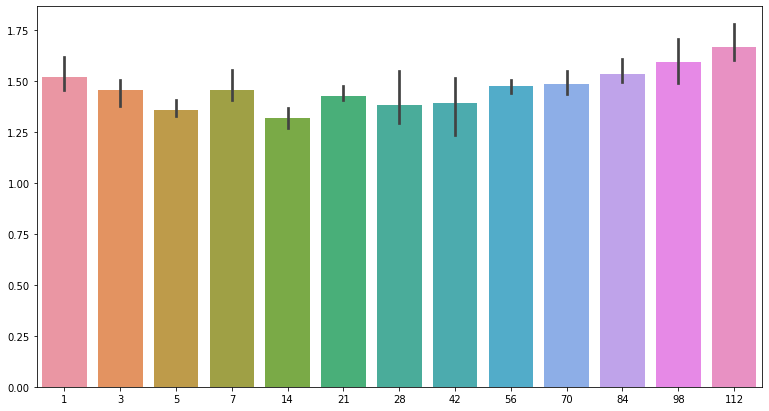

OFFSET 5


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


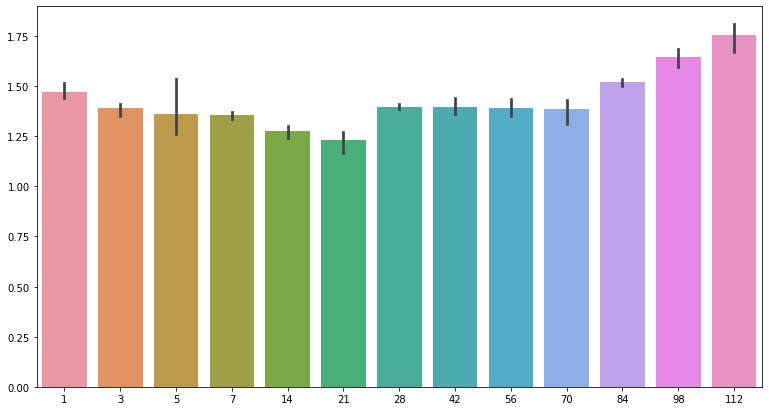

OFFSET 7


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


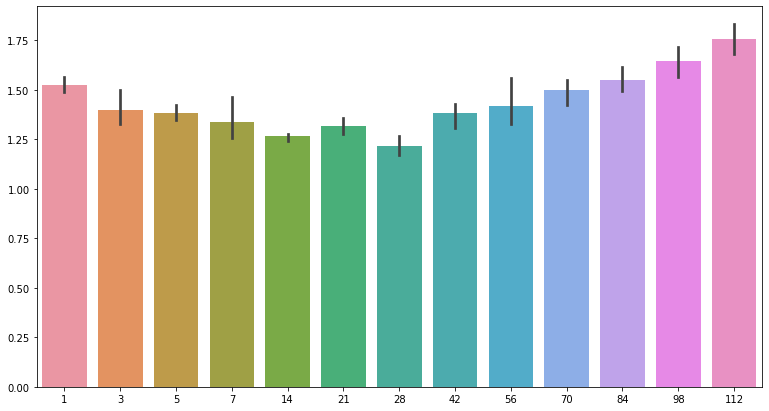

OFFSET 14


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


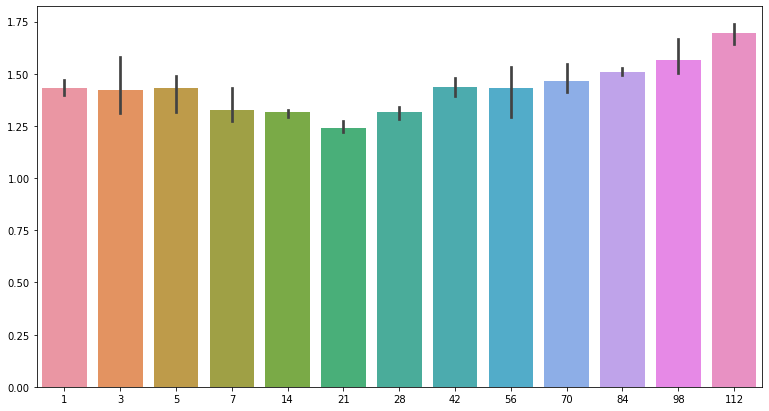

OFFSET 21


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


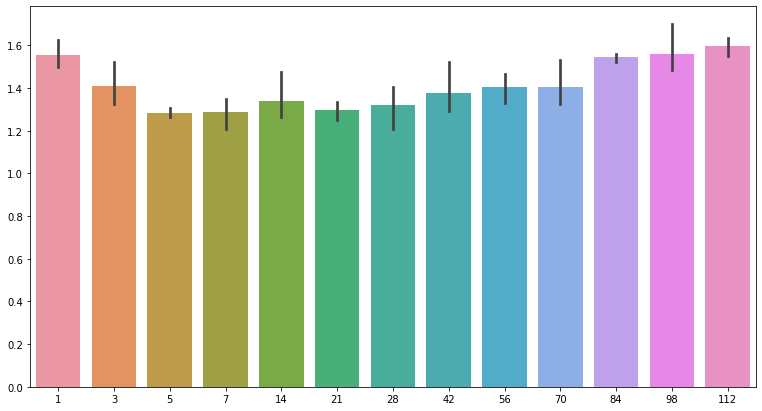

OFFSET 28


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


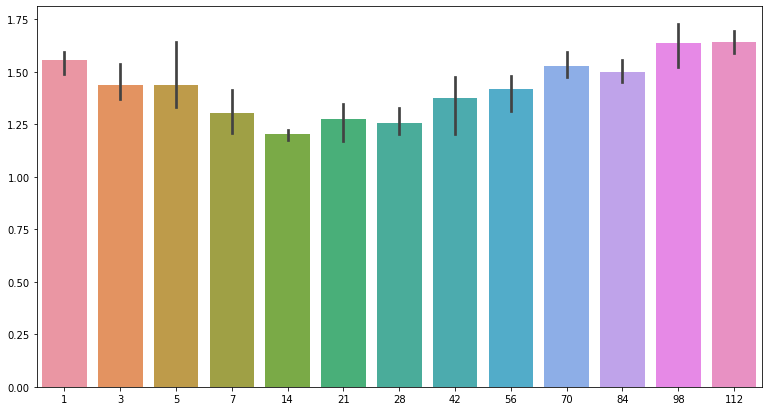

In [ ]:
for i,off in enumerate(offsets):
  print('OFFSET', off)
  x = [item for sublist in val_maes[i] for item in sublist]
  y = np.repeat([[e] for e in prevs], executions, axis=1)
  y = [item for sublist in y for item in sublist]
  sns.barplot(y, x)
  plt.show();

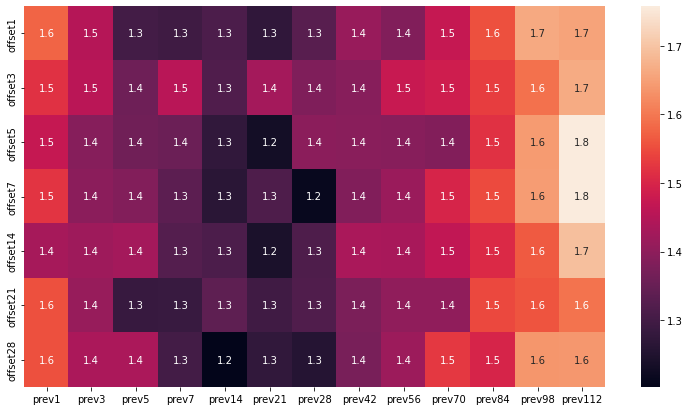

In [ ]:
index = ['offset'+str(o) for o in offsets]
cols = ['prev'+str(p) for p in prevs]
df = pd.DataFrame(avg_val_maes, index=index, columns=cols)
sns.heatmap(df, annot=True)

salvo modelli per migliore prev di ogni offset

In [ ]:
for i,off in enumerate(offsets):
  X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, best_prevs[i], off)

  X_train = X_train.reshape(len(X_train),-1)
  X_val = X_val.reshape(len(X_val),-1)
  X_test = X_test.reshape(len(X_test),-1)

  model = get_network(X_train.shape[1])
  model.compile(loss=loss, optimizer=optimizer)
  model.fit(X_train, y_train, 
            epochs=epochs, batch_size=batch_size, 
            validation_data=(X_val, y_val), 
            callbacks=[stop_callback], 
            verbose=0)
  model.save(base_path+'Models/nn/model_'+target+'_offset'+str(off))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/industrylab/Models/nn/model_portata_offset1/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/industrylab/Models/nn/model_portata_offset3/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/industrylab/Models/nn/model_portata_offset5/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/industrylab/Models/nn/model_portata_offset7/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/industrylab/Models/nn/model_portata_offset14/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/industrylab/Models/nn/model_portata_offset21/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/industrylab/Models/nn/model_portata_offset28/assets


salvo modelli per ogni prev, offset

In [7]:
for i,off in enumerate(offsets):
  for prev in prevs:
    X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, prev, off)

    X_train = X_train.reshape(len(X_train),-1)
    X_val = X_val.reshape(len(X_val),-1)
    X_test = X_test.reshape(len(X_test),-1)

    model = get_network(X_train.shape[1])
    model.compile(loss=loss, optimizer=optimizer)
    model.fit(X_train, y_train, 
              epochs=epochs, batch_size=batch_size, 
              validation_data=(X_val, y_val), 
              callbacks=[stop_callback], 
              verbose=0)
    model.save(base_path+'Models/nn/model_'+target+'_offset'+str(off)+'_prev'+str(prev))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/industrylab/Models/nn/model_portata_offset1_prev1/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/industrylab/Models/nn/model_portata_offset1_prev3/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/industrylab/Models/nn/model_portata_offset1_prev5/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/industrylab/Models/nn/model_portata_offset1_prev7/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/industrylab/Models/nn/model_portata_offset1_prev14/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/industrylab/Models/nn/model_portata_offset1_prev21/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/industrylab/Models/nn/model_portata_offset1_prev28/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/industrylab/Models/nn/model_portata_offset1_prev42/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/industrylab/Models

## LSTM

### Functions

In [ ]:
def create_rnn(arch, prev, n_features, **hyp):
  # define parameters
  model = keras.Sequential()

  for layer in range(len(hyp['neurons']) ):
    if layer == len(hyp['neurons']) - 1:
      model.add(arch(hyp['neurons'][layer ], return_sequences=False,
                                  kernel_initializer=tf.keras.initializers.Constant(0.1)))
    else:
      model.add(arch(hyp['neurons'][layer ], return_sequences=True,
                                  kernel_initializer=tf.keras.initializers.Constant(0.1)))

    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(hyp['dropouts'][layer ]))

  model.add(keras.layers.Dense(1, kernel_initializer=tf.keras.initializers.Constant(0.1)))

  #TODO loss mae, mse, mape
  model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = [tf.keras.metrics.MeanSquaredError()])

  return model

In [ ]:
def create_lstm(prev, n_features, **hyp):
  return create_rnn(keras.layers.LSTM, prev, n_features, **hyp)

In [ ]:
def train(model, x_train, y_train, x_val, y_val, **data):

  EPOCHS = 20
  BATCH_SIZE = 16

  if 'EPOCHS' in data:
    EPOCHS = data['EPOCHS']
  
  if 'BATCH_SIZE' in data:
    BATCH_SIZE = data['BATCH_SIZE']

  early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)

  history = model.fit(
        x = x_train, 
        y = y_train, 
        batch_size=BATCH_SIZE,
        epochs=EPOCHS, 
        callbacks=[early_stopping], 
        #steps_per_epoch=EVALUATION_INTERVAL, 
        validation_data=(x_val, y_val), 
        #validation_steps=50, 
        verbose=0
  )

  return history, model

### Hyperparameter selection

In [ ]:
hyperparams = [
               {
                   'neurons': [128],
                  'dropouts': [0.2]
               },
               {
                   'neurons': [128, 64],
                  'dropouts': [0.2, 0.2]
               },
               {
                   'neurons': [128, 64, 32],
                  'dropouts': [0.2, 0.2, 0.1]
               }
]

In [ ]:
# test with fixed prev & offset
prev = 7
offset = 7

cur_dir = base_path+'Data/Prepared/offset'+ str(offset) +'_prev'+ str(prev) +'/'
for feature in targets:
  

  X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target=feature, prev=prev, offset=offset)

  dict_errors = {}

  for i, param in enumerate(hyperparams):
    errors = []
    for times in range(10):
      model = create_lstm(prev=prev, n_features=7, neurons=param['neurons'], dropouts=param['dropouts'])
      history, model = train(model, X_train, y_train, X_val, y_val, EPOCHS=20)
      # make predictions
      y_pred = scaler[feature].inverse_transform(model.predict(X_val))
      y_true = scaler[feature].inverse_transform(np.array(y_val).reshape(-1,1))

      # calculate me
      mae = mean_absolute_error(y_true, y_pred)
      errors.append(mae)
    
    dict_errors[str(i)] = errors


  pd.DataFrame(dict_errors).to_csv(base_path+'risultati_lstm/test_hyperparameters_lstm'+feature+'_o'+str(offset)+'_p'+str(prev)+'.csv')

In [ ]:
for feature in ['livello', 'portata']:

  for offset in [7]:

    for prev in [1, 7, 112]: 

      dict_errors = pd.read_csv(base_path+'risultati_lstm/test_hyperparameters_lstm_'+feature+'_o'+str(offset)+'_p'+str(prev)+'.csv')
      fig, ax = plt.subplots()
      ax.boxplot(dict_errors[['0', '1', '2']].T)
      ax.set_xticklabels(['1', '2', '3'])
      plt.title(feature+' offset '+str(offset)+' prev '+str(prev))
      plt.show()

In [ ]:
feature = 'portata'
offset = 7
prev = 7

dict_errors = pd.read_csv(base_path+'risultati_lstm/test_hyperparameters_lstm_'+feature+'_o'+str(offset)+'_p'+str(prev)+'.csv')
fig, ax = plt.subplots()
ax.boxplot(dict_errors[['0', '1', '2']].T)
ax.set_xticklabels(['1', '2', '3'])

### Prev selection

model architecture for feature LIVELLO


model architectures

In [ ]:
#best choice for features
hyperparams = {
                  'portata': {
                      'neurons': [128],
                      'dropouts': [0.2]
                  },
                  'livello': {
                      'neurons': [128, 64],
                      'dropouts': [0.2, 0.2]
                  }
}

for each feature, trains 3 instances for each tuple (offset, prev) to compute the performances 

In [ ]:
for feature in ['portata','livello']:
  
  for offset in offsets: #[ 1,3,5,7,14,21 , 28]:
    df_data = []
    label_prevs = []
    for prev in prevs:# [1,3,5,7,14,21,28,42,56,70, 84, 98, 112]:

      cur_dir = base_path+'Data/Prepared/offset'+str(offset)+'_prev'+str(prev)+'/'

      X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target=feature, prev=prev, offset=offset)
      
      for times in range(3): #3 takes to test convergence
      
        #with strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
        model = create_lstm(prev=prev, n_features=7, neurons=hyperparams[feature]['neurons'], dropouts=hyperparams[feature]['dropouts'])

        # if model weights already exist load them
        if os.path.exists(base_path + 'Models/lstm/'+ feature+ str(times)+ 'offset'+ str(offset)+ 'prev'+ str(prev)+'.h5'):
          model.build((1, prev, 7)) # build necessaria?
          model.load_weights(base_path + 'Models/lstm/'+ feature+ str(times)+ 'offset'+ str(offset)+ 'prev'+ str(prev)+'.h5')
        else:
          history, model = train(model, X_train, y_train, X_val, y_val, EPOCHS=20)
          model.save_weights(base_path + 'Models/lstm/'+ feature+ str(times)+ 'offset'+ str(offset)+ 'prev'+ str(prev)+'.h5')

        # make predictions on validation with scaled data
        y_pred = scaler[feature].inverse_transform(model.predict(X_val))
        y_true = scaler[feature].inverse_transform(np.array(y_val).reshape(-1,1))
        #np.min(history.history['val_loss'])
        # calculate mse, mae
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)

        label_prevs.append(prev)
        df_data.append([offset, prev, mse, mae])
        print('done',str(times), 'offset', str(offset), 'prev', str(prev))
        del model
        del y_pred, y_true
      del X_train, X_val, X_test, y_train, y_val, y_test
      

    df = pd.DataFrame(df_data, columns=['offset','prev', 'mse', 'mae'])
    df.to_csv(base_path+'risultati_lstm/mse_lstm_'+feature+'_o'+str(offset)+'.csv')

In [ ]:
feature = 'portata'
offset = 1

df = pd.read_csv(base_path+'risultati_lstm/mse_lstm_'+feature+'_o'+str(offset)+'.csv')

sns.barplot(data=df, x='prev', y='mae') # y can be MAE or MSE
plt.title('offset '+ str(offset))
#plt.savefig(base_path +'offset_'+str(offset) + '.png')
plt.show()

In [ ]:
feature = 'livello'
offset = 1

df = pd.read_csv(base_path+'risultati_lstm/mse_lstm_'+feature+'_o'+str(offset)+'.csv')

sns.barplot(data=df, x='prev', y='mae') # y can be MAE or MSE
plt.title('offset '+ str(offset))
#plt.savefig(base_path +'offset_'+str(offset) + '.png')
plt.show()

# Statistiche finali per il confronto con altri modelli

In [18]:
def get_prev_offset_from_filename(f):
  x = f[(f.index('offset')+len('offset')):]
  offset = x[:x.index('_')]
  x = f[(f.index('prev')+len('prev')):]
  prev = x[:x.index('_')]
  return prev, offset

# grafico sovra-sotto stime
def plot_errors(errors):
  colors = ['g' if x > 0 else 'r' for x in errors]
  plt.bar(range(len(y_true)), errors, color=colors)
  plt.show();


hyperparams = [
               {
                   'neurons': [128],
                  'dropouts': [0.2]
               },
               {
                   'neurons': [128, 64],
                  'dropouts': [0.2, 0.2]
               },
               {
                   'neurons': [128, 64, 32],
                  'dropouts': [0.2, 0.2, 0.1]
               }
]


def create_lstm(prev, n_features, **hyp):
  return create_rnn(keras.layers.LSTM, prev, n_features, **hyp)

def create_rnn(arch, prev, n_features, **hyp):
  # define parameters
  model = keras.Sequential()

  for layer in range(len(hyp['neurons'])):
    if layer == len(hyp['neurons']) - 1:
      model.add(arch(hyp['neurons'][layer ], return_sequences=False,
                                  kernel_initializer=tf.keras.initializers.Constant(0.1)))
    else:
      model.add(arch(hyp['neurons'][layer ], return_sequences=True,
                                  kernel_initializer=tf.keras.initializers.Constant(0.1)))

    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(hyp['dropouts'][layer ]))

  model.add(keras.layers.Dense(1, kernel_initializer=tf.keras.initializers.Constant(0.1)))

  model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = [tf.keras.metrics.MeanSquaredError()])

  return model


plt.rcParams["figure.figsize"] = (13,7)

## confronto mae

livello


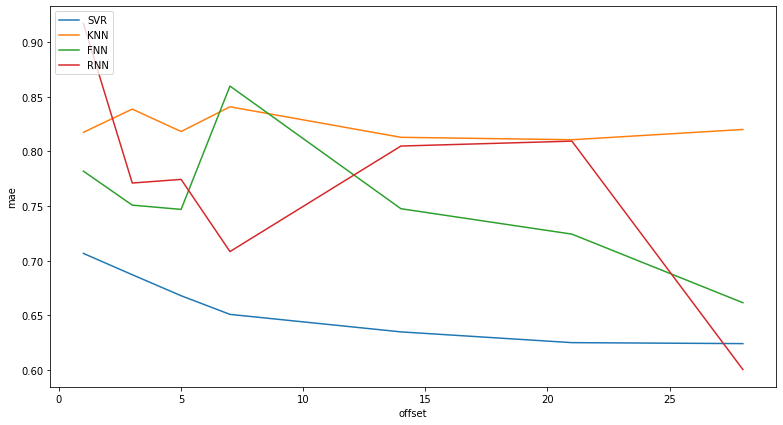

portata


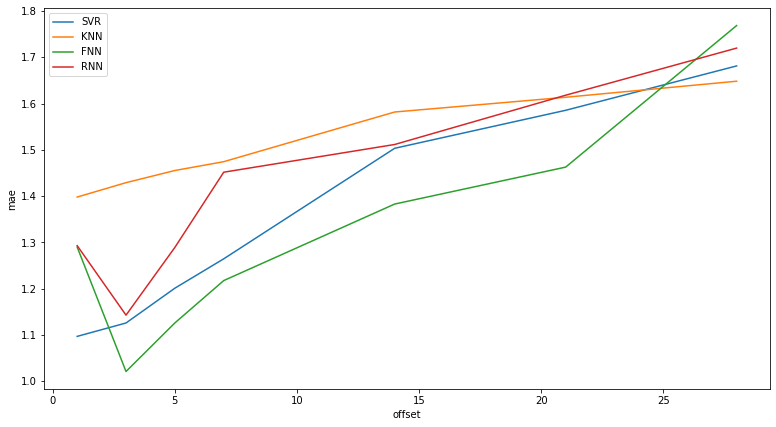

In [ ]:
for target in targets:

  print(target)

  # ------------------------
  # SVR 
  # ------------------------

  tot_errors = []

  tmp_path = base_path+'Models/svr/'
  files = [tmp_path+f for f in os.listdir(tmp_path) if 'results' not in f and target in f]
  for f in files:
    prev, offset = get_prev_offset_from_filename(f)

    X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, int(prev), int(offset))

    X_train = X_train.reshape(len(X_train),-1)
    X_val = X_val.reshape(len(X_val),-1)
    X_test = X_test.reshape(len(X_test),-1)
    
    model = joblib.load(base_path+'Models/svr/svr_offset'+str(offset)+'_prev'+str(prev)+'_'+target+'.joblib')

    y_pred = scaler[target].inverse_transform(model.predict(X_val).reshape(-1,1))
    y_true = scaler[target].inverse_transform(np.array(y_val).reshape(-1,1))
    mae = mean_absolute_error(y_true, y_pred)
    tot_errors.append(mae)
  
  df = pd.DataFrame(np.array([tot_errors]).reshape(-1,1), columns=['mae'])
  df['offset'] = offsets
  sns.lineplot(data=df, x='offset', y='mae', label='SVR')


  # ------------------------
  # KNN 
  # ------------------------

  tot_errors = []

  tmp_path = base_path+'Models/knn/'
  files = [tmp_path+f for f in os.listdir(tmp_path) if 'results' not in f and target in f]
  for f in files:
    prev, offset = get_prev_offset_from_filename(f)

    X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, int(prev), int(offset))

    X_train = X_train.reshape(len(X_train),-1)
    X_val = X_val.reshape(len(X_val),-1)
    X_test = X_test.reshape(len(X_test),-1)
    
    model = joblib.load(base_path+'Models/knn/knn_offset'+str(offset)+'_prev'+str(prev)+'_'+target+'.joblib')

    y_pred = scaler[target].inverse_transform(model.predict(X_val))
    y_true = scaler[target].inverse_transform(np.array(y_val).reshape(-1,1))
    mae = mean_absolute_error(y_true, y_pred)
    tot_errors.append(mae)

  df = pd.DataFrame(np.array([tot_errors]).reshape(-1,1), columns=['mae'])
  df['offset'] = offsets
  sns.lineplot(data=df, x='offset', y='mae', label='KNN')


  # ------------------------
  # FNN 
  # ------------------------

  with open(base_path+'Models/nn/nn_'+target+'_best_prevs.json', 'r') as f:
      best_prevs_dict = json.load(f)

  tot_errors = []
  for offset, best_prev in best_prevs_dict.items():
    
    model = keras.models.load_model(base_path+'Models/nn/model_'+target+'_offset'+str(offset))
    X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, int(best_prev), int(offset))

    X_train = X_train.reshape(len(X_train),-1)
    X_val = X_val.reshape(len(X_val),-1)
    X_test = X_test.reshape(len(X_test),-1)

    y_pred = scaler[target].inverse_transform(model.predict(X_val))
    y_true = scaler[target].inverse_transform(np.array(y_val).reshape(-1,1))
    mae = mean_absolute_error(y_true, y_pred)
    tot_errors.append(mae)
  
  df = pd.DataFrame(np.array([tot_errors]).reshape(-1,1), columns=['mae'])
  df['offset'] = offsets
  sns.lineplot(data=df, x='offset', y='mae', label='FNN')


  # ------------------------
  # RNN 
  # ------------------------

  arch = '1'
  if target == 'portata':
    arch='2'
  df = pd.concat([pd.read_csv(base_path+'risultati_lstm/arch'+arch+'/mse_lstm_'+target+'_o'+str(offset)+'.csv') for offset in offsets])
  df = df[['offset', 'prev', 'mae']]
  df = df.groupby(['offset', 'prev']).mean().reset_index()
  df_pivot = df.pivot(columns='prev', index='offset',values='mae')
  df = pd.DataFrame(np.min(df_pivot.values, axis=1).reshape(-1,1), columns=['mae'])
  df['offset'] = df_pivot.index
  sns.lineplot(data=df, x='offset', y='mae', label='RNN')


  plt.legend(loc='upper left')
  plt.show();

## confronto sovra-sotto stime

------------------------
        livello
------------------------

SVR, mae = 0.651


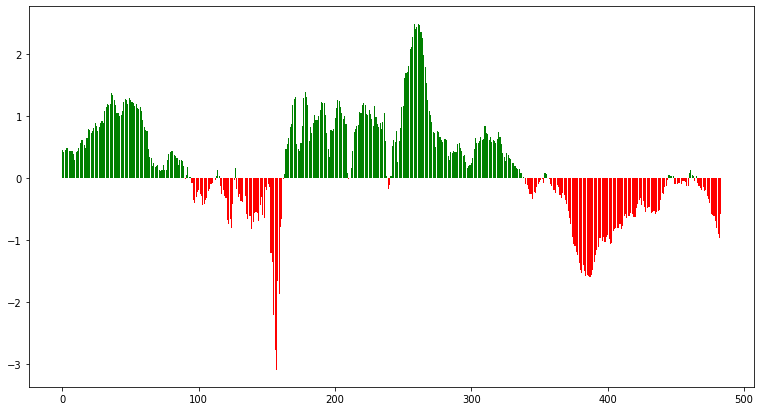


KNN, mae = 0.811


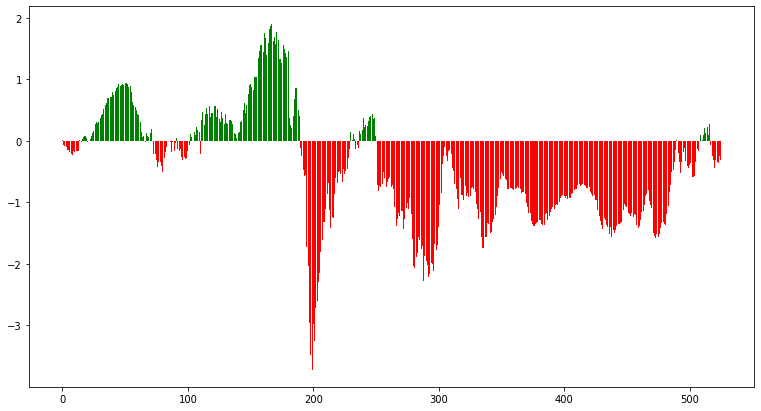

{'1': 98, '3': 98, '5': 112, '7': 98, '14': 98, '21': 98, '28': 98}

FNN, mae = 0.86


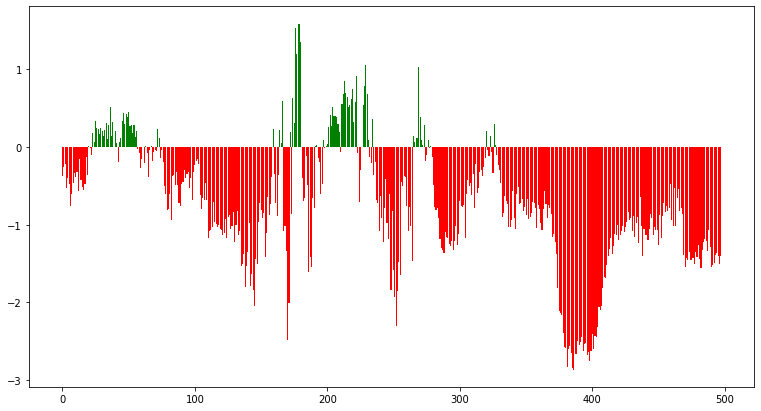


RNN, mae = 0.71


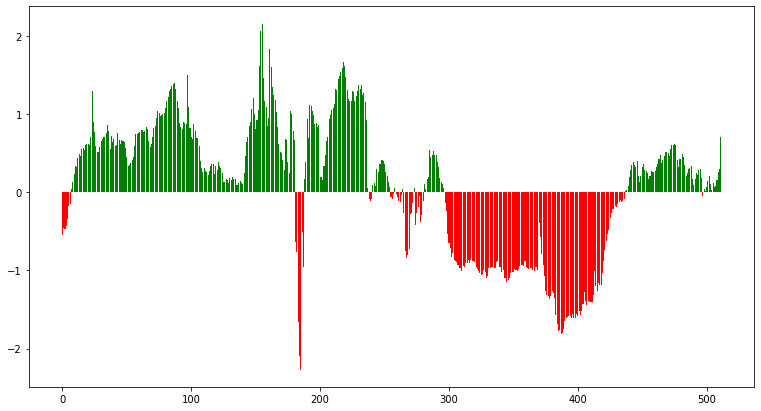

------------------------
        portata
------------------------

SVR, mae = 1.265


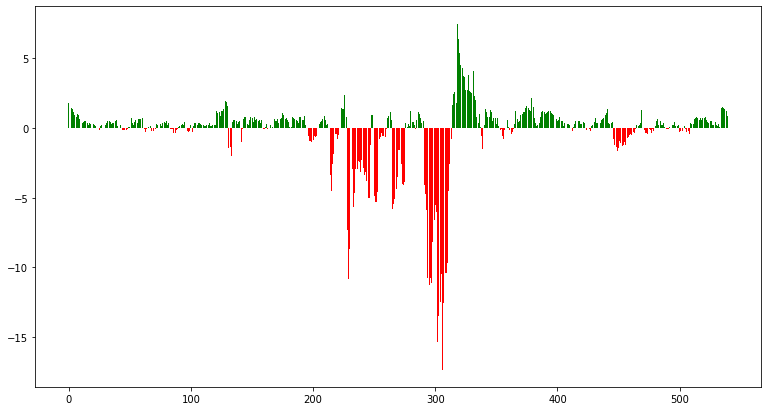


KNN, mae = 1.475


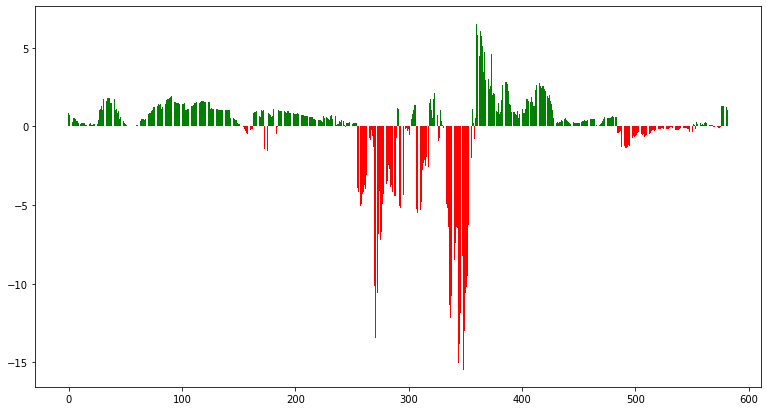

{'1': 21, '3': 14, '5': 21, '7': 28, '14': 21, '21': 5, '28': 14}

FNN, mae = 1.218


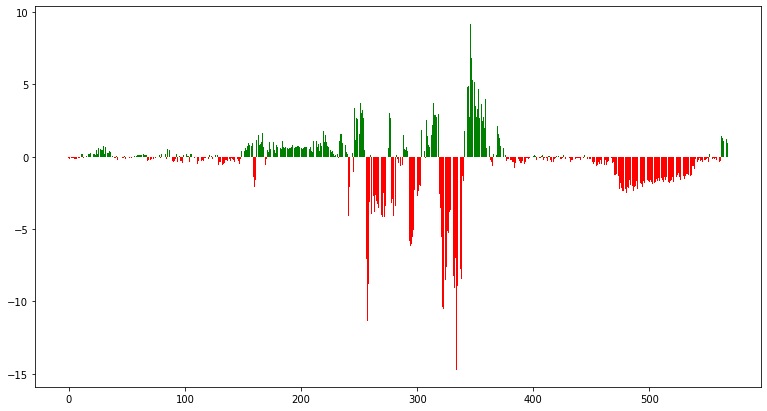


RNN, mae = 1.492


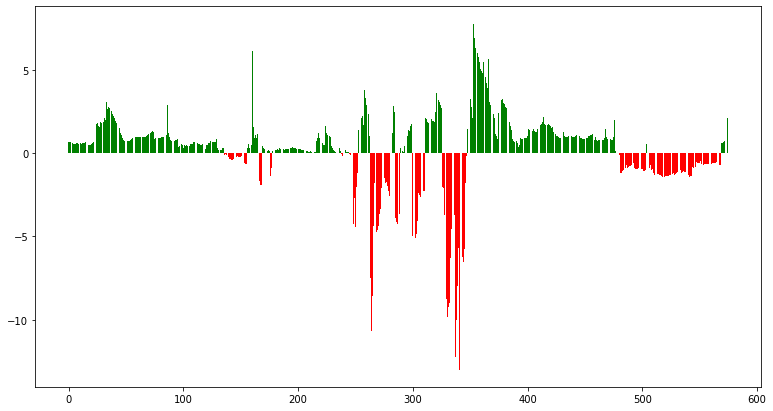

In [ ]:
offset = 7

for target in targets:

  print('------------------------')
  print('       ', target)
  print('------------------------')

  # ------------------------
  # SVR 
  # ------------------------

  tmp_path = base_path+'Models/svr/'
  files = [str(tmp_path+f) for f in os.listdir(tmp_path) if 'results' not in f and target in f]
  filename = [f for f in files if 'offset'+str(offset) in f and target in f][0]
  prev, offset = get_prev_offset_from_filename(filename)

  X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, int(prev), int(offset))

  X_train = X_train.reshape(len(X_train),-1)
  X_val = X_val.reshape(len(X_val),-1)
  X_test = X_test.reshape(len(X_test),-1)

  model = joblib.load(filename)

  y_pred = scaler[target].inverse_transform(model.predict(X_val).reshape(-1,1))
  y_true = scaler[target].inverse_transform(np.array(y_val).reshape(-1,1))
  errors = (np.array(y_pred) - np.array(y_true)).reshape(-1)
  mae = mean_absolute_error(y_true, y_pred)

  print('\nSVR, mae =', mae.round(3))
  plot_errors(errors)


  # ------------------------
  # KNN 
  # ------------------------

  tmp_path = base_path+'Models/knn/'
  files = [str(tmp_path+f) for f in os.listdir(tmp_path) if 'results' not in f and target in f]
  filename = [f for f in files if 'offset'+str(offset) in f and target in f][0]
  prev, offset = get_prev_offset_from_filename(filename)

  X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, int(prev), int(offset))

  X_train = X_train.reshape(len(X_train),-1)
  X_val = X_val.reshape(len(X_val),-1)
  X_test = X_test.reshape(len(X_test),-1)

  model = joblib.load(filename)

  y_pred = scaler[target].inverse_transform(model.predict(X_val))
  y_true = scaler[target].inverse_transform(np.array(y_val).reshape(-1,1))

  errors = (np.array(y_pred) - np.array(y_true)).reshape(-1)
  mae = mean_absolute_error(y_true, y_pred)

  print('\nKNN, mae =', mae.round(3))
  plot_errors(errors)


  # ------------------------
  # FNN 
  # ------------------------

  with open(base_path+'Models/nn/nn_'+target+'_best_prevs.json', 'r') as f:
      best_prevs_dict = json.load(f)
  print(best_prevs_dict)
  tot_errors = []
  
  model = keras.models.load_model(base_path+'Models/nn/model_'+target+'_offset'+str(offset))
  X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, best_prevs_dict[str(offset)], int(offset))

  X_train = X_train.reshape(len(X_train),-1)
  X_val = X_val.reshape(len(X_val),-1)
  X_test = X_test.reshape(len(X_test),-1)

  y_pred = scaler[target].inverse_transform(model.predict(X_val))
  y_true = scaler[target].inverse_transform(np.array(y_val).reshape(-1,1))

  errors = (np.array(y_pred) - np.array(y_true)).reshape(-1)
  mae = mean_absolute_error(y_true, y_pred)

  print('\nFNN, mae =', mae.round(3))
  plot_errors(errors)


  # ------------------------
  # RNN 
  # ------------------------

  arch = '1'
  if target == 'portata':
    arch='2'
  df = pd.concat([pd.read_csv(base_path+'risultati_lstm/arch'+arch+'/mse_lstm_'+target+'_o'+str(offset)+'.csv') for offset in offsets])
  df = df[df['offset']==int(offset)]
  df = df.groupby(['prev']).mean().reset_index()
  prev = int(df.iloc[np.argmin(df['mae'])]['prev'])

  param = hyperparams[int(arch)-1]
  model = create_lstm(prev=prev, n_features=7, neurons=param['neurons'], dropouts=param['dropouts'])
  model.build((1, prev, 7))
  model.load_weights(base_path+'Models/lstm/arch'+arch+'/'+target+'0offset'+str(offset)+'prev'+str(prev)+'.h5')
  
  X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, int(prev), int(offset))

  y_pred = scaler[target].inverse_transform(model.predict(X_val))
  y_true = scaler[target].inverse_transform(np.array(y_val).reshape(-1,1))

  errors = (np.array(y_pred) - np.array(y_true)).reshape(-1)
  mae = mean_absolute_error(y_true, y_pred)

  print('\nRNN, mae =', mae.round(3))
  plot_errors(errors)

------------------------
        livello
------------------------

SVR, mae = 0.651

KNN, mae = 0.811

FNN, mae = 0.86

RNN, mae = 0.71


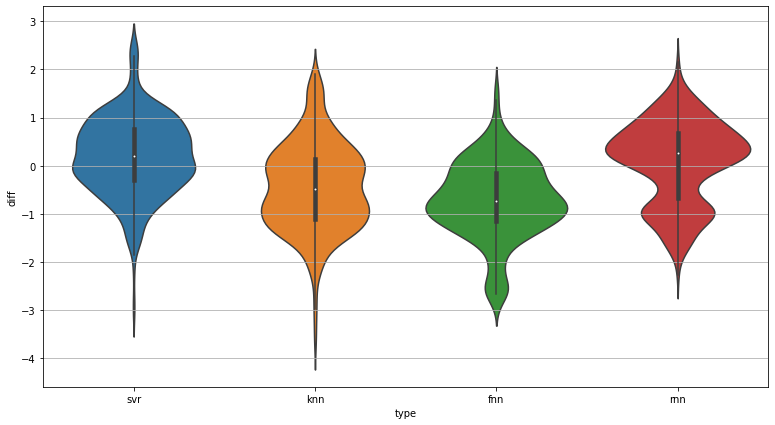

------------------------
        portata
------------------------

SVR, mae = 1.265

KNN, mae = 1.475

FNN, mae = 1.218

RNN, mae = 1.492


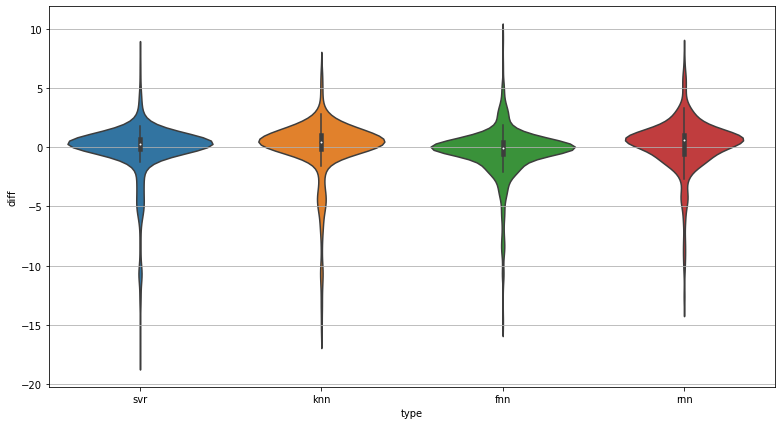

In [ ]:
offset = 7

for target in targets:

  print('------------------------')
  print('       ', target)
  print('------------------------')

  tot_errors = []

  # ------------------------
  # SVR 
  # ------------------------

  tmp_path = base_path+'Models/svr/'
  files = [str(tmp_path+f) for f in os.listdir(tmp_path) if 'results' not in f and target in f]
  filename = [f for f in files if 'offset'+str(offset) in f and target in f][0]
  prev, offset = get_prev_offset_from_filename(filename)

  X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, int(prev), int(offset))

  X_train = X_train.reshape(len(X_train),-1)
  X_val = X_val.reshape(len(X_val),-1)
  X_test = X_test.reshape(len(X_test),-1)

  model = joblib.load(filename)

  y_pred = scaler[target].inverse_transform(model.predict(X_val).reshape(-1,1))
  y_true = scaler[target].inverse_transform(np.array(y_val).reshape(-1,1))
  errors = (np.array(y_pred) - np.array(y_true)).reshape(-1)
  mae = mean_absolute_error(y_true, y_pred)
  tot_errors.append(list(errors))

  print('\nSVR, mae =', mae.round(3))


  # ------------------------
  # KNN 
  # ------------------------

  tmp_path = base_path+'Models/knn/'
  files = [str(tmp_path+f) for f in os.listdir(tmp_path) if 'results' not in f and target in f]
  filename = [f for f in files if 'offset'+str(offset) in f and target in f][0]
  prev, offset = get_prev_offset_from_filename(filename)

  X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, int(prev), int(offset))

  X_train = X_train.reshape(len(X_train),-1)
  X_val = X_val.reshape(len(X_val),-1)
  X_test = X_test.reshape(len(X_test),-1)

  model = joblib.load(filename)

  y_pred = scaler[target].inverse_transform(model.predict(X_val))
  y_true = scaler[target].inverse_transform(np.array(y_val).reshape(-1,1))

  errors = (np.array(y_pred) - np.array(y_true)).reshape(-1)
  mae = mean_absolute_error(y_true, y_pred)
  tot_errors.append(list(errors))

  print('\nKNN, mae =', mae.round(3))


  # ------------------------
  # FNN 
  # ------------------------

  with open(base_path+'Models/nn/nn_'+target+'_best_prevs.json', 'r') as f:
      best_prevs_dict = json.load(f)
  
  model = keras.models.load_model(base_path+'Models/nn/model_'+target+'_offset'+str(offset))
  X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, best_prevs_dict[str(offset)], int(offset))

  X_train = X_train.reshape(len(X_train),-1)
  X_val = X_val.reshape(len(X_val),-1)
  X_test = X_test.reshape(len(X_test),-1)

  y_pred = scaler[target].inverse_transform(model.predict(X_val))
  y_true = scaler[target].inverse_transform(np.array(y_val).reshape(-1,1))

  errors = (np.array(y_pred) - np.array(y_true)).reshape(-1)
  mae = mean_absolute_error(y_true, y_pred)
  tot_errors.append(list(errors))

  print('\nFNN, mae =', mae.round(3))


  # ------------------------
  # RNN 
  # ------------------------

  arch = '1'
  if target == 'portata':
    arch='2'
  df = pd.concat([pd.read_csv(base_path+'risultati_lstm/arch'+arch+'/mse_lstm_'+target+'_o'+str(offset)+'.csv') for offset in offsets])
  df = df[df['offset']==int(offset)]
  df = df.groupby(['prev']).mean().reset_index()
  prev = int(df.iloc[np.argmin(df['mae'])]['prev'])

  param = hyperparams[int(arch)-1]
  model = create_lstm(prev=prev, n_features=7, neurons=param['neurons'], dropouts=param['dropouts'])
  model.build((1, prev, 7))
  model.load_weights(base_path+'Models/lstm/arch'+arch+'/'+target+'0offset'+str(offset)+'prev'+str(prev)+'.h5')
  
  X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, int(prev), int(offset))

  y_pred = scaler[target].inverse_transform(model.predict(X_val))
  y_true = scaler[target].inverse_transform(np.array(y_val).reshape(-1,1))

  errors = (np.array(y_pred) - np.array(y_true)).reshape(-1)
  mae = mean_absolute_error(y_true, y_pred)
  tot_errors.append(list(errors))

  print('\nRNN, mae =', mae.round(3))

  dfs = []
  types = ['svr', 'knn', 'fnn', 'rnn']
  for i,e in enumerate(tot_errors):
    df = pd.DataFrame()
    df['diff'] = e
    df['type'] = [types[i]] * len(df)
    dfs.append(df)
  df = pd.concat(dfs)
  sns.violinplot(data=df, x='type', y='diff').grid(axis='y')
  plt.show();

------------------------
        livello
------------------------

SVR, mae = 0.651

KNN, mae = 0.811


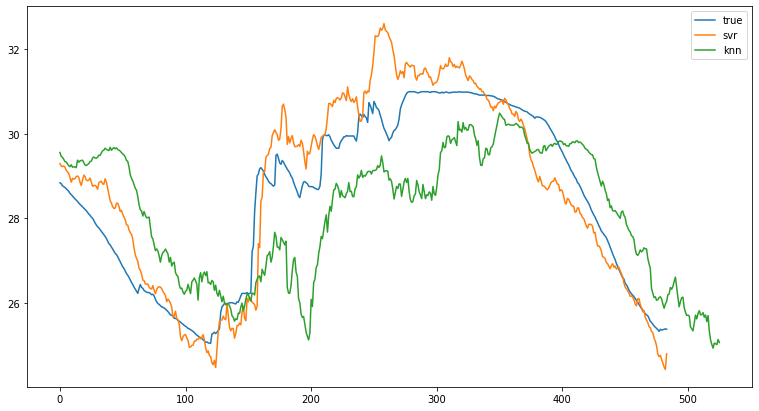

------------------------
        portata
------------------------

SVR, mae = 1.265

KNN, mae = 1.475


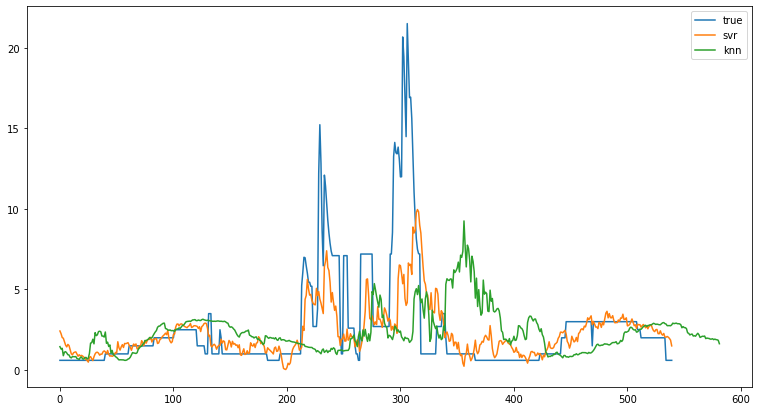

In [ ]:
offset = 7

for target in targets:

  print('------------------------')
  print('       ', target)
  print('------------------------')

  tot_errors = []

  # ------------------------
  # SVR 
  # ------------------------

  tmp_path = base_path+'Models/svr/'
  files = [str(tmp_path+f) for f in os.listdir(tmp_path) if 'results' not in f and target in f]
  filename = [f for f in files if 'offset'+str(offset) in f and target in f][0]
  prev, offset = get_prev_offset_from_filename(filename)

  X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, int(prev), int(offset))

  X_train = X_train.reshape(len(X_train),-1)
  X_val = X_val.reshape(len(X_val),-1)
  X_test = X_test.reshape(len(X_test),-1)

  model = joblib.load(filename)

  y_pred = scaler[target].inverse_transform(model.predict(X_val).reshape(-1,1))
  y_true = scaler[target].inverse_transform(np.array(y_val).reshape(-1,1))
  mae = mean_absolute_error(y_true, y_pred)

  print('\nSVR, mae =', mae.round(3))
  plt.plot(y_true, label='true')
  plt.plot(y_pred, label='svr')


  # ------------------------
  # KNN 
  # ------------------------

  tmp_path = base_path+'Models/knn/'
  files = [str(tmp_path+f) for f in os.listdir(tmp_path) if 'results' not in f and target in f]
  filename = [f for f in files if 'offset'+str(offset) in f and target in f][0]
  prev, offset = get_prev_offset_from_filename(filename)

  X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, int(prev), int(offset))

  X_train = X_train.reshape(len(X_train),-1)
  X_val = X_val.reshape(len(X_val),-1)
  X_test = X_test.reshape(len(X_test),-1)

  model = joblib.load(filename)

  y_pred = scaler[target].inverse_transform(model.predict(X_val))
  y_true = scaler[target].inverse_transform(np.array(y_val).reshape(-1,1))
  mae = mean_absolute_error(y_true, y_pred)

  print('\nKNN, mae =', mae.round(3))
  plt.plot(y_pred, label='knn')
  plt.legend(loc='best')
  plt.show();

------------------------
        livello
------------------------

FNN, mae = 0.86

KNN, mae = 0.811


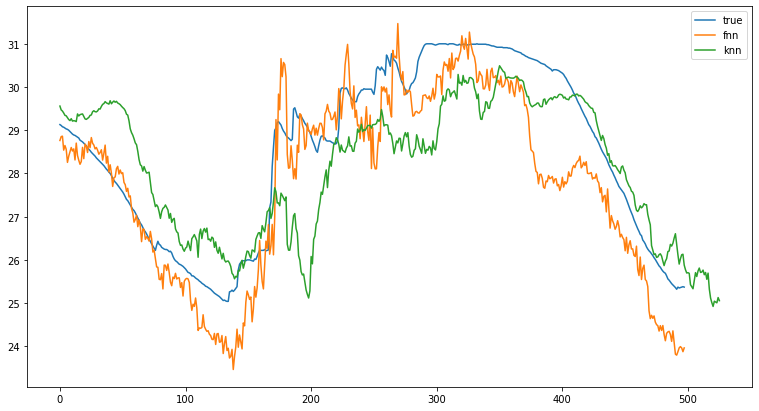

------------------------
        portata
------------------------

FNN, mae = 1.218

KNN, mae = 1.475


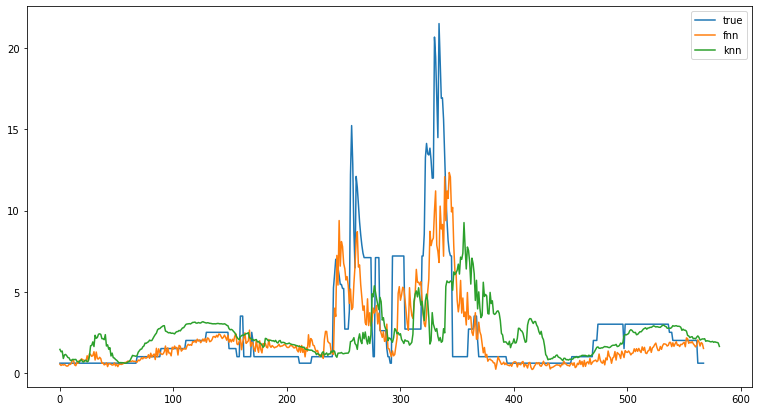

In [24]:
offset = 7

for target in targets:

  print('------------------------')
  print('       ', target)
  print('------------------------')

  tot_errors = []

  # ------------------------
  # FNN
  # ------------------------

  # with open(base_path+'Models/nn/nn_'+target+'_best_prevs.json', 'r') as f:
  #     best_prevs_dict = json.load(f)
  
  
  # X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, best_prevs_dict[str(offset)], int(offset))

  tmp_path = base_path+'Models/nn/'
  files = [str(tmp_path+f) for f in os.listdir(tmp_path) if 'results' not in f and target in f]
  filename = [f for f in files if 'offset'+str(offset) in f and target in f][0]

  with open(base_path+'Models/nn/'+'nn_'+target+'_best_prevs.json') as json_file:
    best_prev = json.load(json_file)

  offset = filename[-1]
  prev = best_prev[offset]

  X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, int(prev), int(offset))

  X_train = X_train.reshape(len(X_train),-1)
  X_val = X_val.reshape(len(X_val),-1)
  X_test = X_test.reshape(len(X_test),-1)

  model = keras.models.load_model(base_path+'Models/nn/model_'+target+'_offset'+str(offset))

  y_pred = scaler[target].inverse_transform(model.predict(X_val).reshape(-1,1))
  y_true = scaler[target].inverse_transform(np.array(y_val).reshape(-1,1))
  mae = mean_absolute_error(y_true, y_pred)

  print('\nFNN, mae =', mae.round(3))
  plt.plot(y_true, label='true')
  plt.plot(y_pred, label='fnn')


  # ------------------------
  # KNN 
  # ------------------------

  tmp_path = base_path+'Models/knn/'
  files = [str(tmp_path+f) for f in os.listdir(tmp_path) if 'results' not in f and target in f]
  filename = [f for f in files if 'offset'+str(offset) in f and target in f][0]
  prev, offset = get_prev_offset_from_filename(filename)

  X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, int(prev), int(offset))

  X_train = X_train.reshape(len(X_train),-1)
  X_val = X_val.reshape(len(X_val),-1)
  X_test = X_test.reshape(len(X_test),-1)

  model = joblib.load(filename)

  y_pred = scaler[target].inverse_transform(model.predict(X_val))
  y_true = scaler[target].inverse_transform(np.array(y_val).reshape(-1,1))
  mae = mean_absolute_error(y_true, y_pred)

  print('\nKNN, mae =', mae.round(3))
  plt.plot(y_pred, label='knn')
  plt.legend(loc='best')
  plt.show();